In [1]:
import pyarrow.dataset as ds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
from statsmodels.stats import stattools
from scipy import stats
import seaborn as sns

In [3]:
from RiskLabAI.controller import Controller

# initialize controller
controller = Controller()

In [4]:
import optuna
from optuna.samplers import TPESampler
from optuna.exceptions import TrialPruned
import torch
print(torch.backends.mps.is_available())

True


# Load Datasets

In [5]:
#Asset under study
ticker = 'BTCUSDT'

# define dataset
dataset = ds.dataset(
    "/Users/bobet/Documents/Code Repository/Trading-Systems/_datasets",
    format="parquet")

# push filter into Arrow scan (faster, uses partition pruning if possible)
table = dataset.to_table(filter=ds.field("symbol") == ticker)

# convert to pandasssss
df = table.to_pandas()
df.tail()

,symbol,ts_ms,iso_utc,ohlc_ts_open,ohlc_open,ohlc_high,ohlc_low,ohlc_close,ohlc_volume,ohlc_ts_close,...,tr_volume_base,tr_volume_quote,tr_vwap,tr_buy_sell_imbalance,spot_price,perp_mark_price,basis_abs,basis_pct,funding_rate,next_funding_time_ms
37904,BTCUSDT,1757746196882,2025-09-13T06:49:56.882944+00:00,1757746140000,115693.77,115693.77,115675.91,115675.91,8.29132,1757746199999,...,13.40075,1.550572e+06,115707.874085,-0.635128,115675.91,115617.10000,-58.81000,-0.000508,0.000035,1757750400000
37905,BTCUSDT,1757746256932,2025-09-13T06:50:56.932928+00:00,1757746200000,115675.92,115675.92,115675.91,115675.91,0.85015,1757746259999,...,9.89241,1.144571e+06,115701.902799,-0.123805,115675.92,115627.50000,-48.42000,-0.000419,0.000034,1757750400000
37906,BTCUSDT,1757746316982,2025-09-13T06:51:56.982649+00:00,1757746260000,115675.92,115714.01,115675.91,115714.00,4.98386,1757746319999,...,21.91183,2.535333e+06,115706.112903,-0.572355,115714.01,115663.23979,-50.77021,-0.000439,0.000034,1757750400000
37907,BTCUSDT,1757746377032,2025-09-13T06:52:57.032633+00:00,1757746320000,115714.01,115714.01,115714.00,115714.00,1.29278,1757746379999,...,22.80020,2.637930e+06,115697.670905,-0.942235,115714.00,115666.70000,-47.30000,-0.000409,0.000034,1757750400000
37908,BTCUSDT,1757746437082,2025-09-13T06:53:57.082743+00:00,1757746380000,115714.00,115714.01,115714.00,115714.01,4.57517,1757746439999,...,10.47169,1.211363e+06,115679.782389,-0.634972,115714.00,115669.50000,-44.50000,-0.000385,0.000034,1757750400000


In [6]:
#features
df.columns

Index(['symbol', 'ts_ms', 'iso_utc', 'ohlc_ts_open', 'ohlc_open', 'ohlc_high',
       'ohlc_low', 'ohlc_close', 'ohlc_volume', 'ohlc_ts_close', 'ohlc_trades',
       'ohlc_taker_base', 'ohlc_taker_quote', 'l1_bid', 'l1_ask', 'l1_mid',
       'l1_spread', 'l1_bid_qty', 'l1_ask_qty', 'l1_imbalance', 'l2_bid_depth',
       'l2_ask_depth', 'l2_depth_asymmetry', 'l2_bid_vwap', 'l2_ask_vwap',
       'l2_bid_slope', 'l2_ask_slope', 'tr_volume_base', 'tr_volume_quote',
       'tr_vwap', 'tr_buy_sell_imbalance', 'spot_price', 'perp_mark_price',
       'basis_abs', 'basis_pct', 'funding_rate', 'next_funding_time_ms'],
      dtype='object')

In [7]:
sample_size = df.count()[0]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37909 entries, 0 to 37908
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   symbol                 37909 non-null  object 
 1   ts_ms                  37909 non-null  int64  
 2   iso_utc                37909 non-null  object 
 3   ohlc_ts_open           37909 non-null  int64  
 4   ohlc_open              37909 non-null  float64
 5   ohlc_high              37909 non-null  float64
 6   ohlc_low               37909 non-null  float64
 7   ohlc_close             37909 non-null  float64
 8   ohlc_volume            37909 non-null  float64
 9   ohlc_ts_close          37909 non-null  int64  
 10  ohlc_trades            37909 non-null  int64  
 11  ohlc_taker_base        37909 non-null  float64
 12  ohlc_taker_quote       37909 non-null  float64
 13  l1_bid                 37909 non-null  float64
 14  l1_ask                 37909 non-null  float64
 15  l1

## Raw Features

### General
- **symbol**: Trading pair identifier (e.g., BTCUSDT).  
- **ts_ms**: Data timestamp in milliseconds (epoch time).  
- **iso_utc**: Data timestamp in human-readable UTC format.  

### OHLC Data (Candlestick)
- **ohlc_ts_open**: Opening timestamp for the candlestick period.  
- **ohlc_open**: Opening price of the candlestick.  
- **ohlc_high**: Highest price within the candlestick.  
- **ohlc_low**: Lowest price within the candlestick.  
- **ohlc_close**: Closing price of the candlestick.  
- **ohlc_volume**: Trading volume during the candlestick (base asset units).  
- **ohlc_ts_close**: Closing timestamp for the candlestick period.  
- **ohlc_trades**: Number of trades in the candlestick.  
- **ohlc_taker_base**: Base asset volume traded by takers (aggressors).  
- **ohlc_taker_quote**: Quote asset volume traded by takers.  

### Level 1 Order Book (Top of Book)
- **l1_bid**: Best bid price (highest buy order).  
- **l1_ask**: Best ask price (lowest sell order).  
- **l1_mid**: Midpoint price between bid and ask.  
- **l1_spread**: Difference between best ask and bid (ask - bid).  
- **l1_bid_qty**: Quantity available at best bid.  
- **l1_ask_qty**: Quantity available at best ask.  
- **l1_imbalance**: Order book imbalance at Level 1 = (bid_qty – ask_qty) / (bid_qty + ask_qty).  

### Level 2 Order Book (Depth of Market)
- **l2_bid_depth**: Total buy-side liquidity across multiple bid levels.  
- **l2_ask_depth**: Total sell-side liquidity across multiple ask levels.  
- **l2_depth_asymmetry**: Relative difference between bid and ask depth.  
- **l2_bid_vwap**: Volume-weighted average bid price across order book levels.  
- **l2_ask_vwap**: Volume-weighted average ask price across order book levels.  
- **l2_bid_slope**: Measure of how steeply bid prices rise with quantity (liquidity gradient).  
- **l2_ask_slope**: Measure of how steeply ask prices rise with quantity.  

### Trade Data
- **tr_volume_base**: Total traded volume in base asset.  
- **tr_volume_quote**: Total traded volume in quote asset.  
- **tr_vwap**: Trade volume-weighted average price.  
- **tr_buy_sell_imbalance**: Difference between buy-initiated and sell-initiated trade volumes.  

### Derived Prices
- **spot_price**: Current spot market price.  
- **perp_mark_price**: Mark price used in perpetual futures to avoid manipulation.  
- **basis_abs**: Absolute difference between perpetual mark price and spot price.  
- **basis_pct**: Percentage difference between perpetual mark price and spot price.  
- **funding_rate**: Periodic payment rate between long and short positions in perpetual contracts.  
- **next_funding_time_ms**: Timestamp (ms) of the next funding event.  

## Data hygiene & storage

✔ Why: storage efficiency + ordering. A 10GB dataset may shrink to ~3-4GB when optimized.

In [8]:
# Ensure correct dtypes (saves memory on 10GB dataset)
dtype_map = {
    "symbol": "category",
    "ohlc_open": "float32", "ohlc_high": "float32", "ohlc_low": "float32", "ohlc_close": "float32",
    "ohlc_volume": "float32", "ohlc_trades": "int32",
    "ohlc_taker_base": "float32", "ohlc_taker_quote": "float32",
    "l1_bid": "float32", "l1_ask": "float32", "l1_mid": "float32", "l1_spread": "float32",
    "l1_bid_qty": "float32", "l1_ask_qty": "float32", "l1_imbalance": "float32",
    "l2_bid_depth": "float32", "l2_ask_depth": "float32", "l2_depth_asymmetry": "float32",
    "l2_bid_vwap": "float32", "l2_ask_vwap": "float32",
    "l2_bid_slope": "float32", "l2_ask_slope": "float32",
    "tr_volume_base": "float32", "tr_volume_quote": "float32", "tr_vwap": "float32",
    "tr_buy_sell_imbalance": "float32",
    "spot_price": "float32", "perp_mark_price": "float32",
    "basis_abs": "float32", "basis_pct": "float32", "funding_rate": "float32"
}

df = df.astype(dtype_map)

# Make sure timestamp is datetime
df["iso_utc"] = pd.to_datetime(df["iso_utc"])
df = df.set_index("iso_utc").sort_index()


#Intergrity Check
# Drop duplicates, check ordering
df = df[~df.index.duplicated(keep="first")].sort_index()

# Sanity checks for OHLC
mask = (
    (df["ohlc_low"] <= df["ohlc_open"]) &
    (df["ohlc_low"] <= df["ohlc_close"]) &
    (df["ohlc_high"] >= df["ohlc_open"]) &
    (df["ohlc_high"] >= df["ohlc_close"])
)
df = df[mask]

# Check non-negative volumes
df = df[df["ohlc_volume"] >= 0]

## Convert DataFrame to RiskLA AI Input Format

In [9]:
df_riskAI = df.copy()
df_riskAI = df_riskAI.loc[:, ['symbol', 'ohlc_close', 'ohlc_volume']]
#rename column
df_riskAI.reset_index(inplace=True) 
df_riskAI.set_index('symbol', inplace=True)
df_riskAI.columns = ['date', 'price', 'volume']
df_riskAI.head()

,date,price,volume
symbol,,,
BTCUSDT,2025-08-17 15:45:47.575950+00:00,118251.351562,0.75580
BTCUSDT,2025-08-17 15:46:47.606265+00:00,118234.531250,5.14589
BTCUSDT,2025-08-17 15:47:47.643040+00:00,118234.531250,2.35213
BTCUSDT,2025-08-17 15:48:47.662644+00:00,118234.523438,6.03409
BTCUSDT,2025-08-17 15:49:47.702649+00:00,118234.523438,1.28289


## Load Existing Parameter Resampling Database

In [10]:
param_db_filename = 'params_resampling-scheme.json'
# Open and load JSON file

def load_param_resampling_db(file_name):
    """
    Load resampling parameter database from a JSON file.

    Parameters
    ----------
    file_name : str
        Path to the JSON file containing the parameter database.

    Returns
    -------
    list of dict
        A list of parameter dictionaries previously stored.
        If the file does not exist or is invalid, returns an empty list.

    Notes
    -----
    - The expected structure is a list of dictionaries where each dictionary
      contains keys such as 'Sampling_Scheme', 'n_trials', 'n_samples', etc.
    - Use together with `sampling_best_params` for managing optimal bar parameters.

    Examples
    --------
    >>> params_db = load_param_resampling_db("params_resampling-scheme.json")
    >>> len(params_db)
    5
    """
    with open(file_name, "r") as f:
        df_params = json.load(f)
    return df_params

db_resampling_params = load_param_resampling_db(param_db_filename)
db_resampling_params

[{'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_tick_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.860134363,
  'Shapiro-Wilk_pvalue': 0.0,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 10000,
  'initial_estimate_of_expected_n_ticks_in_bar': 20000,
  'batch_size': 1000000},
 {'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_volume_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.966333091,
  'Shapiro-Wilk_pvalue': 0.870860279,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 10000,
  'initial_estimate_of_expected_n_ticks_in_bar': 20000,
  'batch_size': 1000000},
 {'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_dollar_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.961657166,
  'Shapiro-Wilk_pvalue': 0.832820237,
  'window_size_for_expected_n_ticks

In [11]:
#load best parameters in the resampling database
def db_resampling_best_params(_sampling_method,db_params):
    """
    Retrieve the best parameter set for a given resampling method
    from the parameter database.

    Parameters
    ----------
    _sampling_method : str
        The sampling scheme to filter on, e.g.:
        - "expected_tick_imbalance_bars"
        - "expected_volume_run_bars"
    db_params : list of dict
        The resampling parameter database, typically loaded from JSON.

    Returns
    -------
    dict
        The best parameter dictionary for the given sampling scheme.

    Notes
    -----
    - Ranking is based on three criteria:
        1. `n_samples` (ascending) → prefer larger sample size.
        2. `Shapiro-Wilk_pvalue` (ascending).
        3. `Shapiro-Wilk_statistic` (ascending).
    - The last row after sorting is returned (`tail(1)`), so effectively it picks 
      the parameters with *highest* sample size, *highest* p-value, and *highest* statistic.

    Examples
    --------
    >>> best = db_resampling_best_params("expected_tick_imbalance_bars", params_db)
    >>> best["n_samples"]
    25000
    """
    db = pd.DataFrame(db_params)
    db = db.loc[db['Sampling_Scheme'] ==_sampling_method]

    # Sort by 'n_samples' first, then by 'Shapiro-Wilk_pvalue', then by 'Shapiro-Wilk_statistic'
    db = db.sort_values(
        by=['n_samples', 'Shapiro-Wilk_pvalue', 'Shapiro-Wilk_statistic'],
        ascending=[True, True, True])   # example: n_samples ↑, pvalue ↓, stat ↓

    return db.tail(1).to_dict(orient="records")[0]

In [12]:
db_best_params = db_resampling_best_params(_sampling_method='expected_dollar_imbalance_bars',db_params=db_resampling_params)
db_best_params

{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_dollar_imbalance_bars',
 'n_trials': 200,
 'n_samples': 29401,
 'Shapiro-Wilk_statistic': 0.9999977946281433,
 'Shapiro-Wilk_pvalue': 0.9971637634369476,
 'window_size_for_expected_n_ticks_estimation': 28,
 'window_size_for_expected_imbalance_estimation': 2622,
 'initial_estimate_of_expected_n_ticks_in_bar': 2772,
 'batch_size': 85682}

# Utilily Functions

## Helper Functions

Summed (additive counts / volumes)

We sum over the ticks inside each bar:
	•	ohlc_trades
	•	ohlc_taker_base
	•	ohlc_taker_quote
	•	tr_volume_base
	•	tr_volume_quote

⸻

Last (state-like snapshots, take the latest tick in the bar)

We forward-fill within the bar only, then take the last available value:
	•	l1_bid, l1_ask, l1_mid, l1_spread
	•	l1_bid_qty, l1_ask_qty, l1_imbalance
	•	l2_bid_depth, l2_ask_depth, l2_depth_asymmetry
	•	l2_bid_vwap, l2_ask_vwap, l2_bid_slope, l2_ask_slope
	•	spot_price, perp_mark_price
	•	basis_abs, basis_pct
	•	funding_rate, next_funding_time_ms

(These are “levels” or “state variables” you’d want at the bar close.)

⸻

Mean (averaged inside the bar)
	•	tr_buy_sell_imbalance

⸻

Weighted mean (value × volume / total volume)
	•	tr_vwap (weighted by tr_volume_base)

(This is the standard definition of VWAP: average trade price weighted by base-asset volume.)

In [13]:
#Compute log returns from a price series.l
log_return = lambda s: np.log(s).diff().dropna()

# Hyper Parameter Optimization with Optuna

## Optimization_Helper Function

In [14]:
def sampling_best_params(sampling_method, df_sample, params_resampling_db, db_file_name, trials=50):

    """
    Tune and persist optimal hyperparameters for imbalance/run bar sampling methods 
    using statistical normality as the optimization criterion.

    This function uses Optuna to search over candidate hyperparameters for
    imbalance/run bar resampling methods. The objective is to maximize the 
    Shapiro–Wilk test statistic of log returns (i.e., make returns "more normal").
    Results are compared against a baseline parameter set (from DB or fallback defaults)
    and optionally saved back to the parameter database if improvement criteria are met.

    Parameters
    ----------
    sampling_method : str
        One of the supported bar sampling methods, e.g.:
        - "expected_tick_imbalance_bars"
        - "expected_volume_imbalance_bars"
        - "expected_dollar_imbalance_bars"
        - "expected_tick_run_bars"
        - "expected_volume_run_bars"
        - "expected_dollar_run_bars"
    df_sample : pandas.DataFrame
        Input trade/quote data used for bar generation based from riskAIlab standard foramat. Must include a `Close` column.
    params_resampling_db : json
        Existing parameter database loaded in memory (list of param dicts).
    db_file_name : str
        file name of JSON database file where parameter database is persisted.
    trials : int, default=50
        Number of Optuna trials to run for hyperparameter search.

    Returns
    -------
    dict
        Best parameter set including:
        - ticker (str)
        - Sampling_Scheme (str)
        - n_trials (int)
        - n_samples (int)
        - Shapiro–Wilk_statistic (float)
        - Shapiro–Wilk_pvalue (float)
        - window_size_for_expected_n_ticks_estimation (int)
        - window_size_for_expected_imbalance_estimation (int)
        - initial_estimate_of_expected_n_ticks_in_bar (int)
        - batch_size (int)

    Notes
    -----
    - Optuna minimizes `1 - Shapiro_stat`, so higher Shapiro–Wilk statistics are preferred.
    - Trials with too few data points or zero variance are pruned early.
    - Only updates the parameter database if:
        * sample size is larger than existing best, OR
        * same sample size but p-value improves.
    - A baseline parameter set is always enqueued as the first trial.
    - Uses `TPESampler(seed=42)` for reproducibility.

    Examples
    --------
    >>> best_params = sampling_best_params(
    ...     sampling_method="expected_tick_imbalance_bars",
    ...     df_sample=my_trades,
    ...     params_resampling_db=params_db,
    ...     db_file_name="resampling_params.json",
    ...     trials=100

    """

    # ---- preload baseline from DB, with fallback
    try:
        _db_best_params = db_resampling_best_params(_sampling_method=sampling_method, db_params=params_resampling_db)
        baseline_params = {
            "window_size_for_expected_n_ticks_estimation": int(_db_best_params["window_size_for_expected_n_ticks_estimation"]),
            "window_size_for_expected_imbalance_estimation": int(_db_best_params["window_size_for_expected_imbalance_estimation"]),
            "initial_estimate_of_expected_n_ticks_in_bar": int(_db_best_params["initial_estimate_of_expected_n_ticks_in_bar"]),
            "batch_size": int(_db_best_params["batch_size"]),
        }
    except Exception:
        # sensible midpoints as a fallback
        baseline_params = {
            "window_size_for_expected_n_ticks_estimation": 5,
            "window_size_for_expected_imbalance_estimation": 10000,
            "initial_estimate_of_expected_n_ticks_in_bar": 20000,
            "batch_size": 1_000_000,
        }

    def objective(trial):
        # Hyperparameters to tune
        param = {
            "window_size_for_expected_n_ticks_estimation": trial.suggest_int("window_size_for_expected_n_ticks_estimation", 1, 50),
            "window_size_for_expected_imbalance_estimation": trial.suggest_int("window_size_for_expected_imbalance_estimation", 100, 20000),
            "initial_estimate_of_expected_n_ticks_in_bar": trial.suggest_int("initial_estimate_of_expected_n_ticks_in_bar", 500, 20000),
            # or log-scale (Optuna ≥3 supports log for suggest_int)
            "batch_size": trial.suggest_int("batch_size", 50_000, 2_000_000, log=True)
        }

        # detect if this is the enqueued baseline trial
        is_baseline = all(trial.params.get(k) == v for k, v in baseline_params.items())

        # Generate imbalance bars
        info_driven_bar = controller.handle_input_command(
            method_name=sampling_method,
            method_arguments={
                "window_size_for_expected_n_ticks_estimation": param["window_size_for_expected_n_ticks_estimation"],
                "window_size_for_expected_imbalance_estimation": param["window_size_for_expected_imbalance_estimation"],
                "initial_estimate_of_expected_n_ticks_in_bar": param["initial_estimate_of_expected_n_ticks_in_bar"],
            },
            input_data=df_sample,
            batch_size=param["batch_size"],
        )
        
        # Compute returns from info_driven_bar
        info_driven_bar_returns = log_return(info_driven_bar['Close'])

        # guardrails
        if info_driven_bar_returns.size < 3 or np.allclose(np.var(info_driven_bar_returns), 0.0):
            # baseline must NEVER be pruned; return a penalty instead
            if is_baseline:
                return 1.0
            raise TrialPruned("Not enough data / zero variance")


        # Shapiro-Wilk test
        #minimum 3 datapoints
        # --- Guardrails for Shapiro ---
        # too few points → either prune or penalize
        if info_driven_bar_returns.size < 3:
            # Prefer pruning so Optuna doesn’t waste time on bad regions:
            raise optuna.TrialPruned("Not enough data points for Shapiro (need >= 3).")
            # or alternatively: return 1.0  # penalty

        # zero variance also breaks normality tests
        if np.allclose(np.var(info_driven_bar_returns ), 0.0):
            raise optuna.TrialPruned("Zero-variance returns.")

        # Shapiro recommended max n=5000; subsample if larger
        if info_driven_bar_returns.size > 5000:
            rng = np.random.default_rng(42)
            idx = rng.choice(info_driven_bar_returns.size, size=5000, replace=False)
            sample = info_driven_bar_returns[idx]
        else:
            sample = info_driven_bar_returns
        
        # --- Shapiro–Wilk test ---
        # We want "more normal" = better → maximize statistic (close to 1).
        # Optuna minimizes by default, so we return (1 - stat).
        try:
            stat, pval = stats.shapiro(sample)
        except ValueError as e:
            # e.g., numerical issues → prune this trial
            raise optuna.TrialPruned(f"Shapiro failed: {e}")

        # Store extra values for later inspection
        trial.set_user_attr("shapiro_stat", float(stat))
        trial.set_user_attr("shapiro_pval", float(pval))


        return 1.0 - float(stat)  # lower is better (stat closer to 1)
    
    def _saved_to_db (_new_params, db, file_name):
        params_resampling_db.append(_new_params)
        with open(file_name, "w") as f:
            json.dump(params_resampling_db, f, indent=4)

    # ---- run study
    study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=42))# minimize 1 - stat
    study.enqueue_trial(baseline_params)
    study.optimize(objective, n_trials=trials)


    best = study.best_trial   # <--- define best here

    sample_size = len(df_sample)
    new_stat = best.user_attrs.get('shapiro_stat')
    new_pvalue =best.user_attrs.get('shapiro_pval')

    new_params = {  'ticker': df_sample.index.unique()[0],
                    'Sampling_Scheme': sampling_method,
                    'n_trials' : trials,
                    'n_samples': sample_size,
                    'Shapiro-Wilk_statistic': new_stat ,
                    'Shapiro-Wilk_pvalue': new_pvalue ,
                } | study.best_params 

    
    # save new param set to database if not already present
    if new_params in params_resampling_db:
        print("⚠️ Resampling parameters already exist in the database.")
    
    elif new_pvalue is None or new_stat is None:
        print(
            "ℹ️ New parameters contain None values — keeping existing best parameters.\n"
            f"New params candidate: {new_params}\n"
            f"Existing best params: {_db_best_params}"
            )
        return _db_best_params
    else:
        #Saved to database
        if sample_size > _db_best_params["n_samples"]:
            _saved_to_db(_new_params=new_params, db=params_resampling_db, file_name=db_file_name)
            print(
                f"✅ Saved new parameters (larger sample size: {sample_size} vs "
                f"{_db_best_params['n_samples']})."
            )
            return new_params
        #skip new paramaters
        elif sample_size < _db_best_params["n_samples"]:
            print(
                f"ℹ️  Smaller sample size ({sample_size} vs {_db_best_params['n_samples']}). "
                "Keeping existing best parameters."
            )
            return _db_best_params
        #Saved to database
        elif (
            sample_size == _db_best_params["n_samples"]
            and new_pvalue > _db_best_params["Shapiro-Wilk_pvalue"]
        ):
            _saved_to_db(_new_params=new_params, db=params_resampling_db, file_name=db_file_name)
            print(
                f"🔄 Same sample size ({sample_size}) but better p-value "
                f"({new_pvalue:.4f} vs {_db_best_params['Shapiro-Wilk_pvalue']:.4f}). "
                "Updated with new parameters."
            )
            return new_params
        #skip new paramaters       
        else:
            print("ℹ️ Did not satisfy update conditions — keeping existing best parameters.")
            print("New params candidate:", new_params)
            print("Existing best params:", _db_best_params)
            return _db_best_params

## Optimized Sampling Schemes Parameters

### Optimized Imbalance Bars

In [15]:
n_trials = 200

##### Imbalance Tick Bars Parameters

In [16]:
params_expected_tick_bars = sampling_best_params(sampling_method='expected_tick_imbalance_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=n_trials)
params_expected_tick_bars

[I 2025-09-13 15:05:59,334] A new study created in memory with name: no-name-509ada1b-b1ca-4050-bd97-4d0f3d901ffc
[I 2025-09-13 15:05:59,495] Trial 0 finished with value: 0.031795620918273926 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 7211, 'initial_estimate_of_expected_n_ticks_in_bar': 6600, 'batch_size': 970131}. Best is trial 0 with value: 0.031795620918273926.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:06:09,697] Trial 1 finished with value: 0.11191534996032715 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 19020, 'initial_estimate_of_expected_n_ticks_in_bar': 14774, 'batch_size': 455046}. Best is trial 0 with value: 0.031795620918273926.


Processing batch 0 with size 37909


[I 2025-09-13 15:06:12,973] Trial 2 finished with value: 0.09579896926879883 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3204, 'initial_estimate_of_expected_n_ticks_in_bar': 1632, 'batch_size': 1220775}. Best is trial 0 with value: 0.031795620918273926.


Processing batch 0 with size 37909


[I 2025-09-13 15:06:24,757] Trial 3 finished with value: 0.09974145889282227 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 14191, 'initial_estimate_of_expected_n_ticks_in_bar': 901, 'batch_size': 1789879}. Best is trial 0 with value: 0.031795620918273926.
[I 2025-09-13 15:06:24,914] Trial 4 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:06:25,074] Trial 5 pruned. Not enough data / zero variance
[I 2025-09-13 15:06:25,374] Trial 6 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:06:25,535] Trial 7 pruned. Not enough data / zero variance
[I 2025-09-13 15:06:25,693] Trial 8 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:06:35,202] Trial 9 finished with value: 0.08536243438720703 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 18983, 'initial_estimate_of_expected_n_ticks_in_bar': 19330, 'batch_size': 986439}. Best is trial 0 with value: 0.031795620918273926.


Processing batch 0 with size 37909


[I 2025-09-13 15:06:35,499] Trial 10 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:06:40,194] Trial 11 finished with value: 0.1228289008140564 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 9447, 'initial_estimate_of_expected_n_ticks_in_bar': 19566, 'batch_size': 743027}. Best is trial 0 with value: 0.031795620918273926.


Processing batch 0 with size 37909


[I 2025-09-13 15:06:50,040] Trial 12 finished with value: 0.07562828063964844 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 19917, 'initial_estimate_of_expected_n_ticks_in_bar': 19852, 'batch_size': 1237153}. Best is trial 0 with value: 0.031795620918273926.


Processing batch 0 with size 37909


[I 2025-09-13 15:06:50,311] Trial 13 pruned. Not enough data / zero variance
[I 2025-09-13 15:06:50,472] Trial 14 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:06:50,636] Trial 15 pruned. Not enough data / zero variance
[I 2025-09-13 15:06:50,799] Trial 16 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:06:51,085] Trial 17 pruned. Not enough data / zero variance
[I 2025-09-13 15:06:51,247] Trial 18 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:06:51,409] Trial 19 pruned. Not enough data / zero variance
[I 2025-09-13 15:06:51,569] Trial 20 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:07:00,573] Trial 21 finished with value: 0.12157559394836426 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 19725, 'initial_estimate_of_expected_n_ticks_in_bar': 19545, 'batch_size': 945763}. Best is trial 0 with value: 0.031795620918273926.
[I 2025-09-13 15:07:00,741] Trial 22 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:07:00,911] Trial 23 pruned. Not enough data / zero variance
[I 2025-09-13 15:07:01,080] Trial 24 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:07:09,088] Trial 25 finished with value: 0.0928276777267456 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 16473, 'initial_estimate_of_expected_n_ticks_in_bar': 19527, 'batch_size': 831577}. Best is trial 0 with value: 0.031795620918273926.
[I 2025-09-13 15:07:09,256] Trial 26 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:07:09,423] Trial 27 pruned. Not enough data / zero variance
[I 2025-09-13 15:07:09,588] Trial 28 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:07:09,903] Trial 29 pruned. Not enough data / zero variance
[I 2025-09-13 15:07:10,065] Trial 30 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:07:18,084] Trial 31 finished with value: 0.10628277063369751 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 16326, 'initial_estimate_of_expected_n_ticks_in_bar': 19947, 'batch_size': 791691}. Best is trial 0 with value: 0.031795620918273926.
[I 2025-09-13 15:07:18,249] Trial 32 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:07:27,388] Trial 33 finished with value: 0.09770232439041138 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 17173, 'initial_estimate_of_expected_n_ticks_in_bar': 18481, 'batch_size': 716991}. Best is trial 0 with value: 0.031795620918273926.
[I 2025-09-13 15:07:27,549] Trial 34 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:07:37,749] Trial 35 finished with value: 0.11283755302429199 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 18414, 'initial_estimate_of_expected_n_ticks_in_bar': 14858, 'batch_size': 1105186}. Best is trial 0 with value: 0.031795620918273926.


Processing batch 0 with size 37909


[I 2025-09-13 15:07:38,047] Trial 36 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:07:48,501] Trial 37 finished with value: 0.06821537017822266 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 16817, 'initial_estimate_of_expected_n_ticks_in_bar': 4819, 'batch_size': 908429}. Best is trial 0 with value: 0.031795620918273926.


Processing batch 0 with size 37909


[I 2025-09-13 15:08:01,857] Trial 38 finished with value: 0.25001949071884155 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 18954, 'initial_estimate_of_expected_n_ticks_in_bar': 2793, 'batch_size': 417396}. Best is trial 0 with value: 0.031795620918273926.


Processing batch 0 with size 37909


[I 2025-09-13 15:08:02,117] Trial 39 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:08:08,461] Trial 40 finished with value: 0.15173852443695068 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 8143, 'initial_estimate_of_expected_n_ticks_in_bar': 5516, 'batch_size': 1532786}. Best is trial 0 with value: 0.031795620918273926.


Processing batch 0 with size 37909


[I 2025-09-13 15:08:21,968] Trial 41 finished with value: 0.12401062250137329 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 17212, 'initial_estimate_of_expected_n_ticks_in_bar': 912, 'batch_size': 940428}. Best is trial 0 with value: 0.031795620918273926.


Processing batch 0 with size 37909


[I 2025-09-13 15:08:33,381] Trial 42 finished with value: 0.1108781099319458 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 14035, 'initial_estimate_of_expected_n_ticks_in_bar': 1955, 'batch_size': 824533}. Best is trial 0 with value: 0.031795620918273926.
[I 2025-09-13 15:08:33,543] Trial 43 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:08:33,708] Trial 44 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:08:41,489] Trial 45 finished with value: 0.08123219013214111 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 15059, 'initial_estimate_of_expected_n_ticks_in_bar': 19010, 'batch_size': 166688}. Best is trial 0 with value: 0.031795620918273926.
[I 2025-09-13 15:08:41,653] Trial 46 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:08:51,408] Trial 47 finished with value: 0.09730780124664307 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 18977, 'initial_estimate_of_expected_n_ticks_in_bar': 18900, 'batch_size': 183165}. Best is trial 0 with value: 0.031795620918273926.


Processing batch 0 with size 37909


[I 2025-09-13 15:08:51,677] Trial 48 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:09:03,324] Trial 49 finished with value: 0.06927108764648438 and parameters: {'window_size_for_expected_n_ticks_estimation': 38, 'window_size_for_expected_imbalance_estimation': 17864, 'initial_estimate_of_expected_n_ticks_in_bar': 5916, 'batch_size': 132969}. Best is trial 0 with value: 0.031795620918273926.
[I 2025-09-13 15:09:03,488] Trial 50 finished with value: 0.041862308979034424 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 6025, 'initial_estimate_of_expected_n_ticks_in_bar': 5773, 'batch_size': 120170}. Best is trial 0 with value: 0.031795620918273926.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:03,652] Trial 51 finished with value: 0.0195847749710083 and parameters: {'window_size_for_expected_n_ticks_estimation': 38, 'window_size_for_expected_imbalance_estimation': 5716, 'initial_estimate_of_expected_n_ticks_in_bar': 6661, 'batch_size': 118905}. Best is trial 51 with value: 0.0195847749710083.
[I 2025-09-13 15:09:03,961] Trial 52 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:04,123] Trial 53 finished with value: 0.03626364469528198 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 3834, 'initial_estimate_of_expected_n_ticks_in_bar': 7251, 'batch_size': 73345}. Best is trial 51 with value: 0.0195847749710083.
[I 2025-09-13 15:09:04,286] Trial 54 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:04,455] Trial 55 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:09:04,760] Trial 56 finished with value: 0.09393155574798584 and parameters: {'window_size_for_expected_n_ticks_estimation': 38, 'window_size_for_expected_imbalance_estimation': 1618, 'initial_estimate_of_expected_n_ticks_in_bar': 4963, 'batch_size': 133511}. Best is trial 51 with value: 0.0195847749710083.
[I 2025-09-13 15:09:04,930] Trial 57 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:05,093] Trial 58 pruned. Not enough data / zero variance
[I 2025-09-13 15:09:05,259] Trial 59 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:05,427] Trial 60 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:09:09,002] Trial 61 finished with value: 0.13420796394348145 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 3870, 'initial_estimate_of_expected_n_ticks_in_bar': 5395, 'batch_size': 60564}. Best is trial 51 with value: 0.0195847749710083.
[I 2025-09-13 15:09:09,167] Trial 62 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:09,334] Trial 63 finished with value: 0.004542231559753418 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 4969, 'initial_estimate_of_expected_n_ticks_in_bar': 6151, 'batch_size': 96112}. Best is trial 63 with value: 0.004542231559753418.


Processing batch 0 with size 37909


[I 2025-09-13 15:09:09,629] Trial 64 pruned. Not enough data / zero variance
[I 2025-09-13 15:09:09,793] Trial 65 finished with value: 0.11083906888961792 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 8840, 'initial_estimate_of_expected_n_ticks_in_bar': 2877, 'batch_size': 78871}. Best is trial 63 with value: 0.004542231559753418.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:16,125] Trial 66 finished with value: 0.12085193395614624 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 10230, 'initial_estimate_of_expected_n_ticks_in_bar': 4832, 'batch_size': 157681}. Best is trial 63 with value: 0.004542231559753418.
[I 2025-09-13 15:09:16,289] Trial 67 finished with value: 0.0626903772354126 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 3513, 'initial_estimate_of_expected_n_ticks_in_bar': 7412, 'batch_size': 53215}. Best is trial 63 with value: 0.004542231559753418.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:16,590] Trial 68 finished with value: 0.07077920436859131 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 5710, 'initial_estimate_of_expected_n_ticks_in_bar': 7284, 'batch_size': 53456}. Best is trial 63 with value: 0.004542231559753418.
[I 2025-09-13 15:09:16,757] Trial 69 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:16,927] Trial 70 pruned. Not enough data / zero variance
[I 2025-09-13 15:09:17,093] Trial 71 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:22,572] Trial 72 finished with value: 0.08091384172439575 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 6861, 'initial_estimate_of_expected_n_ticks_in_bar': 5658, 'batch_size': 87439}. Best is trial 63 with value: 0.004542231559753418.


Processing batch 0 with size 37909


[I 2025-09-13 15:09:27,761] Trial 73 finished with value: 0.10815966129302979 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 6278, 'initial_estimate_of_expected_n_ticks_in_bar': 7457, 'batch_size': 227557}. Best is trial 63 with value: 0.004542231559753418.


Processing batch 0 with size 37909


[I 2025-09-13 15:09:28,042] Trial 74 finished with value: 0.08476054668426514 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 7930, 'initial_estimate_of_expected_n_ticks_in_bar': 4534, 'batch_size': 145563}. Best is trial 63 with value: 0.004542231559753418.
[I 2025-09-13 15:09:28,206] Trial 75 finished with value: 0.03571522235870361 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 5476, 'initial_estimate_of_expected_n_ticks_in_bar': 6667, 'batch_size': 93992}. Best is trial 63 with value: 0.004542231559753418.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:28,374] Trial 76 finished with value: 0.10106521844863892 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 1916, 'initial_estimate_of_expected_n_ticks_in_bar': 6650, 'batch_size': 322245}. Best is trial 63 with value: 0.004542231559753418.
[I 2025-09-13 15:09:28,538] Trial 77 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:28,705] Trial 78 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:09:32,623] Trial 79 finished with value: 0.11820870637893677 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 5611, 'initial_estimate_of_expected_n_ticks_in_bar': 5445, 'batch_size': 74712}. Best is trial 63 with value: 0.004542231559753418.
[I 2025-09-13 15:09:32,790] Trial 80 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:32,956] Trial 81 finished with value: 0.028076887130737305 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 6590, 'initial_estimate_of_expected_n_ticks_in_bar': 7018, 'batch_size': 66164}. Best is trial 63 with value: 0.004542231559753418.


Processing batch 0 with size 37909


[I 2025-09-13 15:09:33,269] Trial 82 finished with value: 0.06629621982574463 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 6392, 'initial_estimate_of_expected_n_ticks_in_bar': 6823, 'batch_size': 62170}. Best is trial 63 with value: 0.004542231559753418.
[I 2025-09-13 15:09:33,434] Trial 83 finished with value: 0.007040560245513916 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 6580, 'initial_estimate_of_expected_n_ticks_in_bar': 6718, 'batch_size': 67555}. Best is trial 63 with value: 0.004542231559753418.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:33,601] Trial 84 pruned. Not enough data / zero variance
[I 2025-09-13 15:09:33,770] Trial 85 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:40,667] Trial 86 finished with value: 0.2601342797279358 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 8640, 'initial_estimate_of_expected_n_ticks_in_bar': 7582, 'batch_size': 81694}. Best is trial 63 with value: 0.004542231559753418.
[I 2025-09-13 15:09:40,833] Trial 87 finished with value: 0.009267628192901611 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 6790, 'initial_estimate_of_expected_n_ticks_in_bar': 6474, 'batch_size': 54667}. Best is trial 63 with value: 0.004542231559753418.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:41,001] Trial 88 finished with value: 0.013590097427368164 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 6771, 'initial_estimate_of_expected_n_ticks_in_bar': 6588, 'batch_size': 119542}. Best is trial 63 with value: 0.004542231559753418.


Processing batch 0 with size 37909


[I 2025-09-13 15:09:47,433] Trial 89 finished with value: 0.07432198524475098 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 9605, 'initial_estimate_of_expected_n_ticks_in_bar': 6624, 'batch_size': 77317}. Best is trial 63 with value: 0.004542231559753418.


Processing batch 0 with size 37909


[I 2025-09-13 15:09:47,714] Trial 90 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:09:53,724] Trial 91 finished with value: 0.1514418125152588 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 7697, 'initial_estimate_of_expected_n_ticks_in_bar': 5281, 'batch_size': 119790}. Best is trial 63 with value: 0.004542231559753418.
[I 2025-09-13 15:09:53,891] Trial 92 finished with value: 0.00784754753112793 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 6561, 'initial_estimate_of_expected_n_ticks_in_bar': 5813, 'batch_size': 103954}. Best is trial 63 with value: 0.004542231559753418.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:54,188] Trial 93 pruned. Not enough data / zero variance
[I 2025-09-13 15:09:54,356] Trial 94 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:54,532] Trial 95 pruned. Not enough data / zero variance
[I 2025-09-13 15:09:54,703] Trial 96 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:55,024] Trial 97 pruned. Not enough data / zero variance
[I 2025-09-13 15:09:55,199] Trial 98 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:55,381] Trial 99 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:09:59,170] Trial 100 finished with value: 0.13559234142303467 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 6036, 'initial_estimate_of_expected_n_ticks_in_bar': 5127, 'batch_size': 145484}. Best is trial 63 with value: 0.004542231559753418.


Processing batch 0 with size 37909


[I 2025-09-13 15:09:59,444] Trial 101 pruned. Not enough data / zero variance
[I 2025-09-13 15:09:59,612] Trial 102 finished with value: 0.004120469093322754 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 5908, 'initial_estimate_of_expected_n_ticks_in_bar': 6464, 'batch_size': 128139}. Best is trial 102 with value: 0.004120469093322754.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:09:59,781] Trial 103 finished with value: 0.06400710344314575 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 5593, 'initial_estimate_of_expected_n_ticks_in_bar': 6522, 'batch_size': 132803}. Best is trial 102 with value: 0.004120469093322754.
[I 2025-09-13 15:09:59,947] Trial 104 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:10:00,222] Trial 105 pruned. Not enough data / zero variance
[I 2025-09-13 15:10:00,389] Trial 106 finished with value: 0.1888444423675537 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 7321, 'initial_estimate_of_expected_n_ticks_in_bar': 6105, 'batch_size': 109435}. Best is trial 102 with value: 0.004120469093322754.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:10:00,560] Trial 107 pruned. Not enough data / zero variance
[I 2025-09-13 15:10:00,727] Trial 108 finished with value: 0.0027640461921691895 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 7017, 'initial_estimate_of_expected_n_ticks_in_bar': 6462, 'batch_size': 89881}. Best is trial 108 with value: 0.0027640461921691895.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:10:00,898] Trial 109 finished with value: 0.009404897689819336 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 7000, 'initial_estimate_of_expected_n_ticks_in_bar': 5709, 'batch_size': 125257}. Best is trial 108 with value: 0.0027640461921691895.


Processing batch 0 with size 37909


[I 2025-09-13 15:10:01,205] Trial 110 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:10:06,403] Trial 111 finished with value: 0.2647817134857178 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 6676, 'initial_estimate_of_expected_n_ticks_in_bar': 5644, 'batch_size': 122302}. Best is trial 108 with value: 0.0027640461921691895.
[I 2025-09-13 15:10:06,573] Trial 112 finished with value: 0.10223555564880371 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 7706, 'initial_estimate_of_expected_n_ticks_in_bar': 6645, 'batch_size': 151137}. Best is trial 108 with value: 0.0027640461921691895.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:10:10,306] Trial 113 finished with value: 0.08394396305084229 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 5840, 'initial_estimate_of_expected_n_ticks_in_bar': 5196, 'batch_size': 91902}. Best is trial 108 with value: 0.0027640461921691895.
[I 2025-09-13 15:10:10,474] Trial 114 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:10:10,649] Trial 115 finished with value: 0.03253507614135742 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 6384, 'initial_estimate_of_expected_n_ticks_in_bar': 4721, 'batch_size': 127424}. Best is trial 108 with value: 0.0027640461921691895.
[I 2025-09-13 15:10:10,818] Trial 116 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:10:11,129] Trial 117 finished with value: 0.000694572925567627 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 8471, 'initial_estimate_of_expected_n_ticks_in_bar': 3266, 'batch_size': 123212}. Best is trial 117 with value: 0.000694572925567627.


Processing batch 0 with size 37909


[I 2025-09-13 15:10:17,742] Trial 118 finished with value: 0.12465780973434448 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 8493, 'initial_estimate_of_expected_n_ticks_in_bar': 1268, 'batch_size': 142535}. Best is trial 117 with value: 0.000694572925567627.
[I 2025-09-13 15:10:17,913] Trial 119 finished with value: 0.0017072558403015137 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 8015, 'initial_estimate_of_expected_n_ticks_in_bar': 2672, 'batch_size': 105837}. Best is trial 117 with value: 0.000694572925567627.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:10:25,092] Trial 120 finished with value: 0.09336578845977783 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 7919, 'initial_estimate_of_expected_n_ticks_in_bar': 2286, 'batch_size': 161873}. Best is trial 117 with value: 0.000694572925567627.
[I 2025-09-13 15:10:25,265] Trial 121 finished with value: 0.12597835063934326 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 9548, 'initial_estimate_of_expected_n_ticks_in_bar': 3343, 'batch_size': 115231}. Best is trial 117 with value: 0.000694572925567627.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:10:25,437] Trial 122 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:10:33,836] Trial 123 finished with value: 0.12624353170394897 and parameters: {'window_size_for_expected_n_ticks_estimation': 38, 'window_size_for_expected_imbalance_estimation': 10796, 'initial_estimate_of_expected_n_ticks_in_bar': 2979, 'batch_size': 104337}. Best is trial 117 with value: 0.000694572925567627.


Processing batch 0 with size 37909


[I 2025-09-13 15:10:34,111] Trial 124 finished with value: 0.014216244220733643 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 8997, 'initial_estimate_of_expected_n_ticks_in_bar': 3818, 'batch_size': 86870}. Best is trial 117 with value: 0.000694572925567627.
[I 2025-09-13 15:10:34,280] Trial 125 finished with value: 0.2168668508529663 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 9070, 'initial_estimate_of_expected_n_ticks_in_bar': 2549, 'batch_size': 88126}. Best is trial 117 with value: 0.000694572925567627.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:10:40,406] Trial 126 finished with value: 0.07199329137802124 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 9915, 'initial_estimate_of_expected_n_ticks_in_bar': 3858, 'batch_size': 139870}. Best is trial 117 with value: 0.000694572925567627.


Processing batch 0 with size 37909


[I 2025-09-13 15:10:47,850] Trial 127 finished with value: 0.27453500032424927 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 8285, 'initial_estimate_of_expected_n_ticks_in_bar': 3111, 'batch_size': 126562}. Best is trial 117 with value: 0.000694572925567627.
[I 2025-09-13 15:10:48,017] Trial 128 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:10:54,121] Trial 129 finished with value: 0.08865094184875488 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 8937, 'initial_estimate_of_expected_n_ticks_in_bar': 5702, 'batch_size': 66004}. Best is trial 117 with value: 0.000694572925567627.


Processing batch 0 with size 37909


[I 2025-09-13 15:10:59,787] Trial 130 finished with value: 0.0914354920387268 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 6070, 'initial_estimate_of_expected_n_ticks_in_bar': 2166, 'batch_size': 50885}. Best is trial 117 with value: 0.000694572925567627.


Processing batch 0 with size 37909


[I 2025-09-13 15:11:05,724] Trial 131 finished with value: 0.07485538721084595 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 6501, 'initial_estimate_of_expected_n_ticks_in_bar': 691, 'batch_size': 99416}. Best is trial 117 with value: 0.000694572925567627.


Processing batch 0 with size 37909


[I 2025-09-13 15:11:06,013] Trial 132 finished with value: 0.015093028545379639 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 7914, 'initial_estimate_of_expected_n_ticks_in_bar': 7192, 'batch_size': 113897}. Best is trial 117 with value: 0.000694572925567627.
[I 2025-09-13 15:11:06,186] Trial 133 finished with value: 0.12300562858581543 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 7989, 'initial_estimate_of_expected_n_ticks_in_bar': 5999, 'batch_size': 112899}. Best is trial 117 with value: 0.000694572925567627.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:06,361] Trial 134 pruned. Not enough data / zero variance
[I 2025-09-13 15:11:06,532] Trial 135 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:11,996] Trial 136 finished with value: 0.07074838876724243 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 6872, 'initial_estimate_of_expected_n_ticks_in_bar': 5139, 'batch_size': 135746}. Best is trial 117 with value: 0.000694572925567627.
[I 2025-09-13 15:11:12,169] Trial 137 finished with value: 0.11524814367294312 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 7672, 'initial_estimate_of_expected_n_ticks_in_bar': 7387, 'batch_size': 119879}. Best is trial 117 with value: 0.000694572925567627.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:12,343] Trial 138 pruned. Not enough data / zero variance
[I 2025-09-13 15:11:12,514] Trial 139 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:18,253] Trial 140 finished with value: 0.08269631862640381 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 7186, 'initial_estimate_of_expected_n_ticks_in_bar': 5473, 'batch_size': 153335}. Best is trial 117 with value: 0.000694572925567627.
[I 2025-09-13 15:11:18,422] Trial 141 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:18,596] Trial 142 finished with value: 0.10115933418273926 and parameters: {'window_size_for_expected_n_ticks_estimation': 38, 'window_size_for_expected_imbalance_estimation': 6702, 'initial_estimate_of_expected_n_ticks_in_bar': 6153, 'batch_size': 515349}. Best is trial 117 with value: 0.000694572925567627.
[I 2025-09-13 15:11:18,769] Trial 143 finished with value: 0.1044124960899353 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 5786, 'initial_estimate_of_expected_n_ticks_in_bar': 7190, 'batch_size': 110096}. Best is trial 117 with value: 0.000694572925567627.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:19,069] Trial 144 pruned. Not enough data / zero variance
[I 2025-09-13 15:11:19,242] Trial 145 finished with value: 0.004712283611297607 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 7191, 'initial_estimate_of_expected_n_ticks_in_bar': 5883, 'batch_size': 100407}. Best is trial 117 with value: 0.000694572925567627.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:19,417] Trial 146 finished with value: 0.19678568840026855 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 7187, 'initial_estimate_of_expected_n_ticks_in_bar': 5869, 'batch_size': 99696}. Best is trial 117 with value: 0.000694572925567627.
[I 2025-09-13 15:11:19,586] Trial 147 finished with value: 0.07856571674346924 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 6463, 'initial_estimate_of_expected_n_ticks_in_bar': 4923, 'batch_size': 113489}. Best is trial 117 with value: 0.000694572925567627.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:25,994] Trial 148 finished with value: 0.07432198524475098 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 9310, 'initial_estimate_of_expected_n_ticks_in_bar': 6500, 'batch_size': 82512}. Best is trial 117 with value: 0.000694572925567627.
[I 2025-09-13 15:11:26,166] Trial 149 finished with value: 0.05036485195159912 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 8588, 'initial_estimate_of_expected_n_ticks_in_bar': 6824, 'batch_size': 62613}. Best is trial 117 with value: 0.000694572925567627.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:26,335] Trial 150 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:11:32,103] Trial 151 finished with value: 0.111355721950531 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 6877, 'initial_estimate_of_expected_n_ticks_in_bar': 7565, 'batch_size': 1735069}. Best is trial 117 with value: 0.000694572925567627.
[I 2025-09-13 15:11:32,277] Trial 152 finished with value: 0.0005350112915039062 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 7359, 'initial_estimate_of_expected_n_ticks_in_bar': 6174, 'batch_size': 56331}. Best is trial 152 with value: 0.0005350112915039062.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:38,571] Trial 153 finished with value: 0.15392714738845825 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 8002, 'initial_estimate_of_expected_n_ticks_in_bar': 5534, 'batch_size': 55483}. Best is trial 152 with value: 0.0005350112915039062.
[I 2025-09-13 15:11:38,743] Trial 154 finished with value: 0.00876915454864502 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 7399, 'initial_estimate_of_expected_n_ticks_in_bar': 6162, 'batch_size': 58794}. Best is trial 152 with value: 0.0005350112915039062.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:39,034] Trial 155 finished with value: 0.0007172226905822754 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 7503, 'initial_estimate_of_expected_n_ticks_in_bar': 6179, 'batch_size': 58700}. Best is trial 152 with value: 0.0005350112915039062.
[I 2025-09-13 15:11:39,208] Trial 156 finished with value: 1.5676021575927734e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 7314, 'initial_estimate_of_expected_n_ticks_in_bar': 6083, 'batch_size': 57364}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:39,380] Trial 157 finished with value: 0.0006933808326721191 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 7406, 'initial_estimate_of_expected_n_ticks_in_bar': 6022, 'batch_size': 59057}. Best is trial 156 with value: 1.5676021575927734e-05.
[I 2025-09-13 15:11:39,554] Trial 158 finished with value: 0.03686726093292236 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 7064, 'initial_estimate_of_expected_n_ticks_in_bar': 6094, 'batch_size': 59838}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:45,530] Trial 159 finished with value: 0.12352025508880615 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 7486, 'initial_estimate_of_expected_n_ticks_in_bar': 5300, 'batch_size': 58994}. Best is trial 156 with value: 1.5676021575927734e-05.
[I 2025-09-13 15:11:45,701] Trial 160 finished with value: 0.0029199719429016113 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 7327, 'initial_estimate_of_expected_n_ticks_in_bar': 5863, 'batch_size': 50425}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:45,878] Trial 161 finished with value: 0.0122145414352417 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 7351, 'initial_estimate_of_expected_n_ticks_in_bar': 5842, 'batch_size': 52373}. Best is trial 156 with value: 1.5676021575927734e-05.
[I 2025-09-13 15:11:46,053] Trial 162 finished with value: 0.026618361473083496 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 7386, 'initial_estimate_of_expected_n_ticks_in_bar': 5822, 'batch_size': 50755}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:46,366] Trial 163 finished with value: 0.02826589345932007 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 8206, 'initial_estimate_of_expected_n_ticks_in_bar': 6207, 'batch_size': 55723}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909


[I 2025-09-13 15:11:52,066] Trial 164 finished with value: 0.12357008457183838 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 7334, 'initial_estimate_of_expected_n_ticks_in_bar': 5472, 'batch_size': 54057}. Best is trial 156 with value: 1.5676021575927734e-05.
[I 2025-09-13 15:11:52,240] Trial 165 finished with value: 0.047998905181884766 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 6291, 'initial_estimate_of_expected_n_ticks_in_bar': 4872, 'batch_size': 51232}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:52,413] Trial 166 finished with value: 0.008084774017333984 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 7758, 'initial_estimate_of_expected_n_ticks_in_bar': 5830, 'batch_size': 62767}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909


[I 2025-09-13 15:11:58,593] Trial 167 finished with value: 0.10342180728912354 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 7749, 'initial_estimate_of_expected_n_ticks_in_bar': 5191, 'batch_size': 63736}. Best is trial 156 with value: 1.5676021575927734e-05.
[I 2025-09-13 15:11:58,765] Trial 168 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:58,939] Trial 169 finished with value: 0.038371920585632324 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 6914, 'initial_estimate_of_expected_n_ticks_in_bar': 5687, 'batch_size': 60893}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909


[I 2025-09-13 15:11:59,262] Trial 170 finished with value: 0.04533165693283081 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 6533, 'initial_estimate_of_expected_n_ticks_in_bar': 6429, 'batch_size': 67099}. Best is trial 156 with value: 1.5676021575927734e-05.
[I 2025-09-13 15:11:59,438] Trial 171 finished with value: 0.12242567539215088 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 7529, 'initial_estimate_of_expected_n_ticks_in_bar': 5909, 'batch_size': 56707}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:11:59,616] Trial 172 finished with value: 0.06696021556854248 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 7103, 'initial_estimate_of_expected_n_ticks_in_bar': 6060, 'batch_size': 50118}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909


[I 2025-09-13 15:12:05,878] Trial 173 finished with value: 0.14530479907989502 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 8038, 'initial_estimate_of_expected_n_ticks_in_bar': 5518, 'batch_size': 55496}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909


[I 2025-09-13 15:12:06,159] Trial 174 finished with value: 0.03990143537521362 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 7366, 'initial_estimate_of_expected_n_ticks_in_bar': 4671, 'batch_size': 61328}. Best is trial 156 with value: 1.5676021575927734e-05.
[I 2025-09-13 15:12:06,331] Trial 175 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:06,508] Trial 176 finished with value: 0.029647886753082275 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 6101, 'initial_estimate_of_expected_n_ticks_in_bar': 5803, 'batch_size': 52959}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909


[I 2025-09-13 15:12:12,033] Trial 177 finished with value: 0.2872302532196045 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 6920, 'initial_estimate_of_expected_n_ticks_in_bar': 5095, 'batch_size': 64146}. Best is trial 156 with value: 1.5676021575927734e-05.
[I 2025-09-13 15:12:12,208] Trial 178 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:12,383] Trial 179 finished with value: 0.019707798957824707 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 6589, 'initial_estimate_of_expected_n_ticks_in_bar': 6470, 'batch_size': 59019}. Best is trial 156 with value: 1.5676021575927734e-05.
[I 2025-09-13 15:12:12,561] Trial 180 finished with value: 0.10414975881576538 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 8193, 'initial_estimate_of_expected_n_ticks_in_bar': 6152, 'batch_size': 53932}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:12,877] Trial 181 finished with value: 0.043691277503967285 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 6765, 'initial_estimate_of_expected_n_ticks_in_bar': 6716, 'batch_size': 57216}. Best is trial 156 with value: 1.5676021575927734e-05.
[I 2025-09-13 15:12:13,054] Trial 182 finished with value: 0.008040964603424072 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 7125, 'initial_estimate_of_expected_n_ticks_in_bar': 5806, 'batch_size': 63670}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:13,230] Trial 183 finished with value: 0.015310823917388916 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 7272, 'initial_estimate_of_expected_n_ticks_in_bar': 5751, 'batch_size': 65991}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909


[I 2025-09-13 15:12:19,093] Trial 184 finished with value: 0.08162015676498413 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 7558, 'initial_estimate_of_expected_n_ticks_in_bar': 5373, 'batch_size': 61631}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909


[I 2025-09-13 15:12:19,372] Trial 185 finished with value: 0.05387711524963379 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 7832, 'initial_estimate_of_expected_n_ticks_in_bar': 6266, 'batch_size': 69240}. Best is trial 156 with value: 1.5676021575927734e-05.
[I 2025-09-13 15:12:19,546] Trial 186 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:19,725] Trial 187 finished with value: 0.051837801933288574 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 6246, 'initial_estimate_of_expected_n_ticks_in_bar': 4910, 'batch_size': 75629}. Best is trial 156 with value: 1.5676021575927734e-05.
[I 2025-09-13 15:12:19,899] Trial 188 finished with value: 0.07460415363311768 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 7115, 'initial_estimate_of_expected_n_ticks_in_bar': 5963, 'batch_size': 57705}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:25,340] Trial 189 finished with value: 0.10330313444137573 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 6834, 'initial_estimate_of_expected_n_ticks_in_bar': 5358, 'batch_size': 63300}. Best is trial 156 with value: 1.5676021575927734e-05.
[I 2025-09-13 15:12:25,510] Trial 190 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:25,688] Trial 191 finished with value: 0.0037623047828674316 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 6692, 'initial_estimate_of_expected_n_ticks_in_bar': 6461, 'batch_size': 55424}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909


[I 2025-09-13 15:12:26,001] Trial 192 finished with value: 0.0008689761161804199 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 6299, 'initial_estimate_of_expected_n_ticks_in_bar': 6442, 'batch_size': 54313}. Best is trial 156 with value: 1.5676021575927734e-05.
[I 2025-09-13 15:12:26,177] Trial 193 finished with value: 0.028559744358062744 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 6456, 'initial_estimate_of_expected_n_ticks_in_bar': 6584, 'batch_size': 56430}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:26,355] Trial 194 finished with value: 0.011830270290374756 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 5875, 'initial_estimate_of_expected_n_ticks_in_bar': 6382, 'batch_size': 61642}. Best is trial 156 with value: 1.5676021575927734e-05.
[I 2025-09-13 15:12:26,527] Trial 195 finished with value: 0.16114169359207153 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 5430, 'initial_estimate_of_expected_n_ticks_in_bar': 7150, 'batch_size': 67403}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:26,700] Trial 196 finished with value: 0.0004780888557434082 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 6251, 'initial_estimate_of_expected_n_ticks_in_bar': 6140, 'batch_size': 58163}. Best is trial 156 with value: 1.5676021575927734e-05.


Processing batch 0 with size 37909


[I 2025-09-13 15:12:27,005] Trial 197 pruned. Not enough data / zero variance
[I 2025-09-13 15:12:27,179] Trial 198 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:27,353] Trial 199 finished with value: 0.06584328413009644 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 6575, 'initial_estimate_of_expected_n_ticks_in_bar': 7369, 'batch_size': 64085}. Best is trial 156 with value: 1.5676021575927734e-05.


✅ Saved new parameters (larger sample size: 37909 vs 29401).


{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_tick_imbalance_bars',
 'n_trials': 200,
 'n_samples': 37909,
 'Shapiro-Wilk_statistic': 0.9999843239784241,
 'Shapiro-Wilk_pvalue': 0.9924382826702495,
 'window_size_for_expected_n_ticks_estimation': 35,
 'window_size_for_expected_imbalance_estimation': 7314,
 'initial_estimate_of_expected_n_ticks_in_bar': 6083,
 'batch_size': 57364}

##### Imbalance Volume Bars Parameters

In [17]:
params_expected_volume_bars = sampling_best_params(sampling_method='expected_volume_imbalance_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=n_trials)
params_expected_volume_bars

[I 2025-09-13 15:12:27,368] A new study created in memory with name: no-name-7b558fe8-2f9f-4e47-bee1-de232ae3b7f3
[I 2025-09-13 15:12:27,541] Trial 0 finished with value: 3.3974647521972656e-06 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 2128, 'initial_estimate_of_expected_n_ticks_in_bar': 2645, 'batch_size': 1377345}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:27,854] Trial 1 pruned. Not enough data / zero variance
[I 2025-09-13 15:12:28,011] Trial 2 finished with value: 0.022551000118255615 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3204, 'initial_estimate_of_expected_n_ticks_in_bar': 1632, 'batch_size': 1220775}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:37,739] Trial 3 finished with value: 0.1487511396408081 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 14191, 'initial_estimate_of_expected_n_ticks_in_bar': 901, 'batch_size': 1789879}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:12:37,897] Trial 4 finished with value: 0.15361559391021729 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 4325, 'initial_estimate_of_expected_n_ticks_in_bar': 4045, 'batch_size': 98354}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:45,023] Trial 5 finished with value: 0.11212754249572754 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 10543, 'initial_estimate_of_expected_n_ticks_in_bar': 8923, 'batch_size': 146397}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:12:45,180] Trial 6 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:45,341] Trial 7 finished with value: 0.10806065797805786 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 15725, 'initial_estimate_of_expected_n_ticks_in_bar': 4393, 'batch_size': 333275}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:12:45,635] Trial 8 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:45,795] Trial 9 pruned. Not enough data / zero variance
[I 2025-09-13 15:12:45,958] Trial 10 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:46,123] Trial 11 finished with value: 0.048106253147125244 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 6081, 'initial_estimate_of_expected_n_ticks_in_bar': 800, 'batch_size': 1877654}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:12:46,289] Trial 12 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:46,575] Trial 13 finished with value: 0.08071702718734741 and parameters: {'window_size_for_expected_n_ticks_estimation': 38, 'window_size_for_expected_imbalance_estimation': 8744, 'initial_estimate_of_expected_n_ticks_in_bar': 6493, 'batch_size': 1025452}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:12:46,741] Trial 14 finished with value: 0.032422661781311035 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 4077, 'initial_estimate_of_expected_n_ticks_in_bar': 654, 'batch_size': 592530}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:46,909] Trial 15 pruned. Not enough data / zero variance
[I 2025-09-13 15:12:47,073] Trial 16 finished with value: 0.0018438100814819336 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 2405, 'initial_estimate_of_expected_n_ticks_in_bar': 3066, 'batch_size': 275877}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:47,369] Trial 17 pruned. Not enough data / zero variance
[I 2025-09-13 15:12:47,537] Trial 18 finished with value: 0.0013298392295837402 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 1803, 'initial_estimate_of_expected_n_ticks_in_bar': 3061, 'batch_size': 245968}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:47,704] Trial 19 pruned. Not enough data / zero variance
[I 2025-09-13 15:12:47,870] Trial 20 finished with value: 0.1400517225265503 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 13060, 'initial_estimate_of_expected_n_ticks_in_bar': 5871, 'batch_size': 395763}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:48,164] Trial 21 finished with value: 0.06737565994262695 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 2125, 'initial_estimate_of_expected_n_ticks_in_bar': 3272, 'batch_size': 240986}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:12:48,331] Trial 22 finished with value: 0.07425689697265625 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 5249, 'initial_estimate_of_expected_n_ticks_in_bar': 2698, 'batch_size': 131263}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:48,498] Trial 23 finished with value: 0.0007841587066650391 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 2666, 'initial_estimate_of_expected_n_ticks_in_bar': 5150, 'batch_size': 528975}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:12:48,662] Trial 24 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:48,956] Trial 25 pruned. Not enough data / zero variance
[I 2025-09-13 15:12:49,125] Trial 26 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:49,293] Trial 27 pruned. Not enough data / zero variance
[I 2025-09-13 15:12:49,461] Trial 28 finished with value: 0.15863531827926636 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 6716, 'initial_estimate_of_expected_n_ticks_in_bar': 5135, 'batch_size': 773784}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:49,630] Trial 29 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:12:56,458] Trial 30 finished with value: 0.24934178590774536 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 9239, 'initial_estimate_of_expected_n_ticks_in_bar': 2484, 'batch_size': 343648}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:12:58,440] Trial 31 finished with value: 0.13901633024215698 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 2417, 'initial_estimate_of_expected_n_ticks_in_bar': 3171, 'batch_size': 281732}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:12:58,749] Trial 32 finished with value: 0.11007064580917358 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 3542, 'initial_estimate_of_expected_n_ticks_in_bar': 2139, 'batch_size': 268499}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:12:58,914] Trial 33 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:59,083] Trial 34 pruned. Not enough data / zero variance
[I 2025-09-13 15:12:59,249] Trial 35 finished with value: 0.09153932332992554 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 2706, 'initial_estimate_of_expected_n_ticks_in_bar': 4153, 'batch_size': 457367}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:12:59,414] Trial 36 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:12:59,687] Trial 37 pruned. Not enough data / zero variance
[I 2025-09-13 15:12:59,852] Trial 38 finished with value: 0.11011385917663574 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 5397, 'initial_estimate_of_expected_n_ticks_in_bar': 1401, 'batch_size': 91481}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:00,017] Trial 39 finished with value: 0.14377135038375854 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 11594, 'initial_estimate_of_expected_n_ticks_in_bar': 3704, 'batch_size': 301788}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:13:11,380] Trial 40 finished with value: 0.1851482391357422 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 17345, 'initial_estimate_of_expected_n_ticks_in_bar': 4557, 'batch_size': 160132}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:13:11,687] Trial 41 pruned. Not enough data / zero variance
[I 2025-09-13 15:13:11,849] Trial 42 finished with value: 7.653236389160156e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 2650, 'initial_estimate_of_expected_n_ticks_in_bar': 2678, 'batch_size': 1184677}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:12,017] Trial 43 pruned. Not enough data / zero variance
[I 2025-09-13 15:13:12,183] Trial 44 finished with value: 0.07826370000839233 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 1077, 'initial_estimate_of_expected_n_ticks_in_bar': 2970, 'batch_size': 1162890}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:14,321] Trial 45 finished with value: 0.15539199113845825 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 2441, 'initial_estimate_of_expected_n_ticks_in_bar': 3906, 'batch_size': 952376}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:14,485] Trial 46 finished with value: 0.13900738954544067 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 4168, 'initial_estimate_of_expected_n_ticks_in_bar': 647, 'batch_size': 1571792}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:14,655] Trial 47 pruned. Not enough data / zero variance
[I 2025-09-13 15:13:14,823] Trial 48 finished with value: 0.07094824314117432 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 3844, 'initial_estimate_of_expected_n_ticks_in_bar': 2592, 'batch_size': 216514}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:15,107] Trial 49 pruned. Not enough data / zero variance
[I 2025-09-13 15:13:15,274] Trial 50 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:15,442] Trial 51 finished with value: 0.059902071952819824 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 1918, 'initial_estimate_of_expected_n_ticks_in_bar': 1607, 'batch_size': 1219517}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:13:18,541] Trial 52 finished with value: 0.3454534411430359 and parameters: {'window_size_for_expected_n_ticks_estimation': 3, 'window_size_for_expected_imbalance_estimation': 4484, 'initial_estimate_of_expected_n_ticks_in_bar': 4515, 'batch_size': 644799}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:13:20,699] Trial 53 finished with value: 0.29158449172973633 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 5547, 'initial_estimate_of_expected_n_ticks_in_bar': 3186, 'batch_size': 1706563}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:20,870] Trial 54 finished with value: 0.24175691604614258 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 1993, 'initial_estimate_of_expected_n_ticks_in_bar': 701, 'batch_size': 835922}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:21,040] Trial 55 finished with value: 0.09600186347961426 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 7820, 'initial_estimate_of_expected_n_ticks_in_bar': 3521, 'batch_size': 1320370}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:21,209] Trial 56 finished with value: 0.09465622901916504 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3153, 'initial_estimate_of_expected_n_ticks_in_bar': 2330, 'batch_size': 1109273}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:21,517] Trial 57 pruned. Not enough data / zero variance
[I 2025-09-13 15:13:21,684] Trial 58 finished with value: 0.04920238256454468 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 1387, 'initial_estimate_of_expected_n_ticks_in_bar': 4782, 'batch_size': 256136}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:31,135] Trial 59 finished with value: 0.07989364862442017 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 14598, 'initial_estimate_of_expected_n_ticks_in_bar': 9701, 'batch_size': 212331}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:13:36,389] Trial 60 finished with value: 0.06656700372695923 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 6962, 'initial_estimate_of_expected_n_ticks_in_bar': 3936, 'batch_size': 318622}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:13:39,575] Trial 61 finished with value: 0.3180276155471802 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 4179, 'initial_estimate_of_expected_n_ticks_in_bar': 523, 'batch_size': 577639}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:39,742] Trial 62 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:40,059] Trial 63 pruned. Not enough data / zero variance
[I 2025-09-13 15:13:40,227] Trial 64 finished with value: 0.09831613302230835 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 4947, 'initial_estimate_of_expected_n_ticks_in_bar': 1271, 'batch_size': 413559}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:40,401] Trial 65 pruned. Not enough data / zero variance
[I 2025-09-13 15:13:40,571] Trial 66 finished with value: 0.19195115566253662 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 1827, 'initial_estimate_of_expected_n_ticks_in_bar': 2338, 'batch_size': 598055}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:40,888] Trial 67 pruned. Not enough data / zero variance
[I 2025-09-13 15:13:41,058] Trial 68 finished with value: 0.05471152067184448 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 4002, 'initial_estimate_of_expected_n_ticks_in_bar': 3470, 'batch_size': 844726}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:41,227] Trial 69 finished with value: 0.003127872943878174 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 2338, 'initial_estimate_of_expected_n_ticks_in_bar': 2694, 'batch_size': 163748}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:41,397] Trial 70 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:41,569] Trial 71 finished with value: 0.0023723244667053223 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 2387, 'initial_estimate_of_expected_n_ticks_in_bar': 2698, 'batch_size': 111277}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:13:41,893] Trial 72 finished with value: 0.005418002605438232 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 2359, 'initial_estimate_of_expected_n_ticks_in_bar': 2744, 'batch_size': 76429}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:42,062] Trial 73 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:42,235] Trial 74 finished with value: 0.039073824882507324 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 3024, 'initial_estimate_of_expected_n_ticks_in_bar': 4444, 'batch_size': 114917}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:42,403] Trial 75 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:42,711] Trial 76 finished with value: 0.05322355031967163 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 2113, 'initial_estimate_of_expected_n_ticks_in_bar': 3927, 'batch_size': 69521}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:42,881] Trial 77 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:43,051] Trial 78 pruned. Not enough data / zero variance
[I 2025-09-13 15:13:43,221] Trial 79 finished with value: 0.0012142062187194824 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 1397, 'initial_estimate_of_expected_n_ticks_in_bar': 3533, 'batch_size': 82659}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:43,550] Trial 80 finished with value: 0.0005394220352172852 and parameters: {'window_size_for_expected_n_ticks_estimation': 38, 'window_size_for_expected_imbalance_estimation': 1414, 'initial_estimate_of_expected_n_ticks_in_bar': 4893, 'batch_size': 156610}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:43,720] Trial 81 finished with value: 0.0021945834159851074 and parameters: {'window_size_for_expected_n_ticks_estimation': 38, 'window_size_for_expected_imbalance_estimation': 1450, 'initial_estimate_of_expected_n_ticks_in_bar': 4892, 'batch_size': 105116}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:43,894] Trial 82 pruned. Not enough data / zero variance
[I 2025-09-13 15:13:44,072] Trial 83 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:44,246] Trial 84 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:13:44,543] Trial 85 finished with value: 0.045920372009277344 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 2850, 'initial_estimate_of_expected_n_ticks_in_bar': 4233, 'batch_size': 107641}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:44,709] Trial 86 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:44,880] Trial 87 finished with value: 0.02509409189224243 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 1667, 'initial_estimate_of_expected_n_ticks_in_bar': 3278, 'batch_size': 289912}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:45,052] Trial 88 finished with value: 0.12604308128356934 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 12535, 'initial_estimate_of_expected_n_ticks_in_bar': 6184, 'batch_size': 124013}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:45,367] Trial 89 finished with value: 0.009889662265777588 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 3239, 'initial_estimate_of_expected_n_ticks_in_bar': 3546, 'batch_size': 204139}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:45,536] Trial 90 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:47,515] Trial 91 finished with value: 0.09568792581558228 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 2411, 'initial_estimate_of_expected_n_ticks_in_bar': 4614, 'batch_size': 166867}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:47,684] Trial 92 finished with value: 0.12563204765319824 and parameters: {'window_size_for_expected_n_ticks_estimation': 38, 'window_size_for_expected_imbalance_estimation': 1219, 'initial_estimate_of_expected_n_ticks_in_bar': 2141, 'batch_size': 240343}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:47,985] Trial 93 finished with value: 0.1271449327468872 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 2607, 'initial_estimate_of_expected_n_ticks_in_bar': 1051, 'batch_size': 102387}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:48,155] Trial 94 finished with value: 0.0386662483215332 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 3766, 'initial_estimate_of_expected_n_ticks_in_bar': 4074, 'batch_size': 177990}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:51,245] Trial 95 finished with value: 0.108364999294281 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 4557, 'initial_estimate_of_expected_n_ticks_in_bar': 1634, 'batch_size': 143034}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:13:51,552] Trial 96 finished with value: 0.028278827667236328 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 2066, 'initial_estimate_of_expected_n_ticks_in_bar': 3137, 'batch_size': 257468}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:51,723] Trial 97 finished with value: 0.008262157440185547 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 2847, 'initial_estimate_of_expected_n_ticks_in_bar': 3707, 'batch_size': 119776}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:51,903] Trial 98 pruned. Not enough data / zero variance
[I 2025-09-13 15:13:52,074] Trial 99 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:52,247] Trial 100 finished with value: 0.002431154251098633 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 1548, 'initial_estimate_of_expected_n_ticks_in_bar': 4797, 'batch_size': 65230}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:13:52,571] Trial 101 finished with value: 0.0028517842292785645 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 1516, 'initial_estimate_of_expected_n_ticks_in_bar': 4803, 'batch_size': 68085}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:52,742] Trial 102 finished with value: 0.027610421180725098 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 1528, 'initial_estimate_of_expected_n_ticks_in_bar': 4677, 'batch_size': 58968}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:52,917] Trial 103 finished with value: 0.0020186305046081543 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 1937, 'initial_estimate_of_expected_n_ticks_in_bar': 4296, 'batch_size': 68011}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:53,089] Trial 104 finished with value: 0.018023133277893066 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 1944, 'initial_estimate_of_expected_n_ticks_in_bar': 4225, 'batch_size': 83981}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:53,374] Trial 105 pruned. Not enough data / zero variance
[I 2025-09-13 15:13:53,546] Trial 106 finished with value: 0.0075269341468811035 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 3221, 'initial_estimate_of_expected_n_ticks_in_bar': 3597, 'batch_size': 93290}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:53,721] Trial 107 finished with value: 0.15178024768829346 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 16806, 'initial_estimate_of_expected_n_ticks_in_bar': 5347, 'batch_size': 66502}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:53,902] Trial 108 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:54,212] Trial 109 finished with value: 0.00014090538024902344 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 2642, 'initial_estimate_of_expected_n_ticks_in_bar': 3239, 'batch_size': 77843}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:54,387] Trial 110 finished with value: 0.09286719560623169 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 3651, 'initial_estimate_of_expected_n_ticks_in_bar': 3182, 'batch_size': 105854}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:54,560] Trial 111 finished with value: 0.0007997751235961914 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 2079, 'initial_estimate_of_expected_n_ticks_in_bar': 3942, 'batch_size': 75720}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:54,732] Trial 112 finished with value: 0.10617232322692871 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 2664, 'initial_estimate_of_expected_n_ticks_in_bar': 4037, 'batch_size': 73853}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:54,906] Trial 113 finished with value: 0.18494749069213867 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 2225, 'initial_estimate_of_expected_n_ticks_in_bar': 2001, 'batch_size': 74883}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:13:55,212] Trial 114 finished with value: 0.006992638111114502 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 2059, 'initial_estimate_of_expected_n_ticks_in_bar': 2797, 'batch_size': 1487658}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:55,393] Trial 115 finished with value: 0.0011342763900756836 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 2907, 'initial_estimate_of_expected_n_ticks_in_bar': 3622, 'batch_size': 87219}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:55,572] Trial 116 finished with value: 0.0033264756202697754 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 2972, 'initial_estimate_of_expected_n_ticks_in_bar': 3450, 'batch_size': 78850}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:55,745] Trial 117 finished with value: 0.11165261268615723 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 4334, 'initial_estimate_of_expected_n_ticks_in_bar': 4334, 'batch_size': 90692}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:56,068] Trial 118 finished with value: 0.023333966732025146 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 1226, 'initial_estimate_of_expected_n_ticks_in_bar': 3167, 'batch_size': 54039}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:56,238] Trial 119 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:56,413] Trial 120 pruned. Not enough data / zero variance
[I 2025-09-13 15:13:56,586] Trial 121 finished with value: 0.009662091732025146 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 2653, 'initial_estimate_of_expected_n_ticks_in_bar': 2444, 'batch_size': 70790}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:56,761] Trial 122 finished with value: 0.050927042961120605 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 3387, 'initial_estimate_of_expected_n_ticks_in_bar': 1746, 'batch_size': 81305}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:13:57,054] Trial 123 finished with value: 0.0018526911735534668 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 1742, 'initial_estimate_of_expected_n_ticks_in_bar': 2955, 'batch_size': 62609}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:57,234] Trial 124 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:57,410] Trial 125 pruned. Not enough data / zero variance
[I 2025-09-13 15:13:57,587] Trial 126 finished with value: 0.02884197235107422 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 1892, 'initial_estimate_of_expected_n_ticks_in_bar': 3619, 'batch_size': 313016}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:57,883] Trial 127 pruned. Not enough data / zero variance
[I 2025-09-13 15:13:58,060] Trial 128 finished with value: 0.01689213514328003 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 1546, 'initial_estimate_of_expected_n_ticks_in_bar': 3970, 'batch_size': 1056993}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:58,238] Trial 129 pruned. Not enough data / zero variance
[I 2025-09-13 15:13:58,417] Trial 130 finished with value: 0.16261625289916992 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 4944, 'initial_estimate_of_expected_n_ticks_in_bar': 3515, 'batch_size': 274382}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:58,726] Trial 131 pruned. Not enough data / zero variance
[I 2025-09-13 15:13:58,903] Trial 132 finished with value: 0.06200814247131348 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 1162, 'initial_estimate_of_expected_n_ticks_in_bar': 2374, 'batch_size': 110610}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:59,078] Trial 133 finished with value: 0.08321177959442139 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 1749, 'initial_estimate_of_expected_n_ticks_in_bar': 1425, 'batch_size': 71267}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:59,251] Trial 134 finished with value: 0.04071938991546631 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 2298, 'initial_estimate_of_expected_n_ticks_in_bar': 2485, 'batch_size': 1289430}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:59,545] Trial 135 finished with value: 0.06550490856170654 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 2839, 'initial_estimate_of_expected_n_ticks_in_bar': 3163, 'batch_size': 97930}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:13:59,717] Trial 136 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:13:59,892] Trial 137 finished with value: 0.09365540742874146 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 8669, 'initial_estimate_of_expected_n_ticks_in_bar': 4895, 'batch_size': 125204}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:14:00,065] Trial 138 finished with value: 0.02208101749420166 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 1804, 'initial_estimate_of_expected_n_ticks_in_bar': 4376, 'batch_size': 376871}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:00,243] Trial 139 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:14:00,525] Trial 140 finished with value: 0.04884040355682373 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 1365, 'initial_estimate_of_expected_n_ticks_in_bar': 2694, 'batch_size': 152372}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:14:00,700] Trial 141 finished with value: 0.00018489360809326172 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 2423, 'initial_estimate_of_expected_n_ticks_in_bar': 4832, 'batch_size': 63772}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:00,881] Trial 142 pruned. Not enough data / zero variance
[I 2025-09-13 15:14:01,058] Trial 143 finished with value: 0.057421088218688965 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 2051, 'initial_estimate_of_expected_n_ticks_in_bar': 3377, 'batch_size': 75690}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:03,294] Trial 144 finished with value: 0.15121161937713623 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 2565, 'initial_estimate_of_expected_n_ticks_in_bar': 4582, 'batch_size': 1656314}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:14:03,467] Trial 145 finished with value: 7.092952728271484e-06 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 1367, 'initial_estimate_of_expected_n_ticks_in_bar': 4121, 'batch_size': 93791}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:03,643] Trial 146 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:14:03,973] Trial 147 finished with value: 0.025867044925689697 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 1397, 'initial_estimate_of_expected_n_ticks_in_bar': 4084, 'batch_size': 92253}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:14:04,148] Trial 148 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:04,326] Trial 149 finished with value: 0.15121185779571533 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 11348, 'initial_estimate_of_expected_n_ticks_in_bar': 3774, 'batch_size': 78105}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:14:04,503] Trial 150 finished with value: 0.02968543767929077 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 1783, 'initial_estimate_of_expected_n_ticks_in_bar': 4663, 'batch_size': 69511}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:06,546] Trial 151 finished with value: 0.08688187599182129 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 2247, 'initial_estimate_of_expected_n_ticks_in_bar': 3325, 'batch_size': 111009}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:14:06,717] Trial 152 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:06,893] Trial 153 finished with value: 0.07497811317443848 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 2819, 'initial_estimate_of_expected_n_ticks_in_bar': 4231, 'batch_size': 85273}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:14:07,065] Trial 154 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:07,384] Trial 155 finished with value: 0.22652101516723633 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 2063, 'initial_estimate_of_expected_n_ticks_in_bar': 2279, 'batch_size': 462216}. Best is trial 0 with value: 3.3974647521972656e-06.
[I 2025-09-13 15:14:07,560] Trial 156 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:07,737] Trial 157 pruned. Not enough data / zero variance
[I 2025-09-13 15:14:07,918] Trial 158 finished with value: 0.10588425397872925 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 1625, 'initial_estimate_of_expected_n_ticks_in_bar': 2664, 'batch_size': 1417009}. Best is trial 0 with value: 3.3974647521972656e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:08,095] Trial 159 finished with value: 2.682209014892578e-06 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 2447, 'initial_estimate_of_expected_n_ticks_in_bar': 3603, 'batch_size': 235767}. Best is trial 159 with value: 2.682209014892578e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:14:08,413] Trial 160 pruned. Not enough data / zero variance
[I 2025-09-13 15:14:08,587] Trial 161 finished with value: 0.03610497713088989 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 2319, 'initial_estimate_of_expected_n_ticks_in_bar': 3308, 'batch_size': 280529}. Best is trial 159 with value: 2.682209014892578e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:08,763] Trial 162 finished with value: 0.03892624378204346 and parameters: {'window_size_for_expected_n_ticks_estimation': 38, 'window_size_for_expected_imbalance_estimation': 2626, 'initial_estimate_of_expected_n_ticks_in_bar': 4109, 'batch_size': 55798}. Best is trial 159 with value: 2.682209014892578e-06.
[I 2025-09-13 15:14:08,938] Trial 163 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:09,263] Trial 164 finished with value: 0.0014928579330444336 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 3357, 'initial_estimate_of_expected_n_ticks_in_bar': 3024, 'batch_size': 932436}. Best is trial 159 with value: 2.682209014892578e-06.
[I 2025-09-13 15:14:09,444] Trial 165 finished with value: 0.009863615036010742 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 3165, 'initial_estimate_of_expected_n_ticks_in_bar': 3502, 'batch_size': 255532}. Best is trial 159 with value: 2.682209014892578e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:09,620] Trial 166 finished with value: 0.038929522037506104 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 3675, 'initial_estimate_of_expected_n_ticks_in_bar': 4496, 'batch_size': 951677}. Best is trial 159 with value: 2.682209014892578e-06.
[I 2025-09-13 15:14:09,791] Trial 167 finished with value: 0.0591357946395874 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 1172, 'initial_estimate_of_expected_n_ticks_in_bar': 3112, 'batch_size': 1140607}. Best is trial 159 with value: 2.682209014892578e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:10,109] Trial 168 finished with value: 0.1458883285522461 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 14343, 'initial_estimate_of_expected_n_ticks_in_bar': 1920, 'batch_size': 178919}. Best is trial 159 with value: 2.682209014892578e-06.
[I 2025-09-13 15:14:10,285] Trial 169 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:10,461] Trial 170 finished with value: 0.004958808422088623 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 2121, 'initial_estimate_of_expected_n_ticks_in_bar': 3015, 'batch_size': 243140}. Best is trial 159 with value: 2.682209014892578e-06.
[I 2025-09-13 15:14:10,638] Trial 171 finished with value: 0.01012265682220459 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 2668, 'initial_estimate_of_expected_n_ticks_in_bar': 2480, 'batch_size': 803152}. Best is trial 159 with value: 2.682209014892578e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:10,819] Trial 172 finished with value: 0.0006600022315979004 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 2387, 'initial_estimate_of_expected_n_ticks_in_bar': 2769, 'batch_size': 292548}. Best is trial 159 with value: 2.682209014892578e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:14:11,112] Trial 173 finished with value: 0.05583322048187256 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 1894, 'initial_estimate_of_expected_n_ticks_in_bar': 3548, 'batch_size': 295228}. Best is trial 159 with value: 2.682209014892578e-06.
[I 2025-09-13 15:14:11,287] Trial 174 finished with value: 0.10210239887237549 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 3139, 'initial_estimate_of_expected_n_ticks_in_bar': 4058, 'batch_size': 343612}. Best is trial 159 with value: 2.682209014892578e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:11,468] Trial 175 pruned. Not enough data / zero variance
[I 2025-09-13 15:14:11,644] Trial 176 finished with value: 0.10740458965301514 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 2841, 'initial_estimate_of_expected_n_ticks_in_bar': 4640, 'batch_size': 310339}. Best is trial 159 with value: 2.682209014892578e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:11,964] Trial 177 finished with value: 0.001387178897857666 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 3412, 'initial_estimate_of_expected_n_ticks_in_bar': 3363, 'batch_size': 1261856}. Best is trial 159 with value: 2.682209014892578e-06.
[I 2025-09-13 15:14:12,142] Trial 178 finished with value: 0.11515015363693237 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 3427, 'initial_estimate_of_expected_n_ticks_in_bar': 2198, 'batch_size': 1444431}. Best is trial 159 with value: 2.682209014892578e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:12,319] Trial 179 finished with value: 0.07067006826400757 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 3901, 'initial_estimate_of_expected_n_ticks_in_bar': 3296, 'batch_size': 929905}. Best is trial 159 with value: 2.682209014892578e-06.
[I 2025-09-13 15:14:12,499] Trial 180 finished with value: 0.004099845886230469 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 2435, 'initial_estimate_of_expected_n_ticks_in_bar': 2654, 'batch_size': 1046460}. Best is trial 159 with value: 2.682209014892578e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:12,680] Trial 181 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:14:12,977] Trial 182 finished with value: 0.08531177043914795 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 1425, 'initial_estimate_of_expected_n_ticks_in_bar': 4270, 'batch_size': 1301686}. Best is trial 159 with value: 2.682209014892578e-06.
[I 2025-09-13 15:14:13,150] Trial 183 finished with value: 0.0010304450988769531 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 2806, 'initial_estimate_of_expected_n_ticks_in_bar': 3212, 'batch_size': 710837}. Best is trial 159 with value: 2.682209014892578e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:13,327] Trial 184 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:14:15,881] Trial 185 finished with value: 0.10030412673950195 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 2857, 'initial_estimate_of_expected_n_ticks_in_bar': 1695, 'batch_size': 584699}. Best is trial 159 with value: 2.682209014892578e-06.
[I 2025-09-13 15:14:16,059] Trial 186 finished with value: 0.03172588348388672 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 2133, 'initial_estimate_of_expected_n_ticks_in_bar': 3495, 'batch_size': 647609}. Best is trial 159 with value: 2.682209014892578e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:16,239] Trial 187 pruned. Not enough data / zero variance
[I 2025-09-13 15:14:16,418] Trial 188 finished with value: 0.04860788583755493 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 4298, 'initial_estimate_of_expected_n_ticks_in_bar': 2754, 'batch_size': 1590257}. Best is trial 159 with value: 2.682209014892578e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:16,596] Trial 189 finished with value: 0.11062228679656982 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 3111, 'initial_estimate_of_expected_n_ticks_in_bar': 2213, 'batch_size': 911291}. Best is trial 159 with value: 2.682209014892578e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:14:16,923] Trial 190 finished with value: 0.09123557806015015 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 3671, 'initial_estimate_of_expected_n_ticks_in_bar': 3179, 'batch_size': 546249}. Best is trial 159 with value: 2.682209014892578e-06.
[I 2025-09-13 15:14:17,101] Trial 191 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:17,285] Trial 192 pruned. Not enough data / zero variance
[I 2025-09-13 15:14:17,471] Trial 193 finished with value: 0.02731013298034668 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 1645, 'initial_estimate_of_expected_n_ticks_in_bar': 3277, 'batch_size': 1258071}. Best is trial 159 with value: 2.682209014892578e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:19,558] Trial 194 finished with value: 0.16914904117584229 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 2342, 'initial_estimate_of_expected_n_ticks_in_bar': 4199, 'batch_size': 237893}. Best is trial 159 with value: 2.682209014892578e-06.
[I 2025-09-13 15:14:19,732] Trial 195 finished with value: 0.0643765926361084 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 1864, 'initial_estimate_of_expected_n_ticks_in_bar': 5371, 'batch_size': 81554}. Best is trial 159 with value: 2.682209014892578e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:19,911] Trial 196 finished with value: 0.03316175937652588 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 1284, 'initial_estimate_of_expected_n_ticks_in_bar': 2500, 'batch_size': 1119194}. Best is trial 159 with value: 2.682209014892578e-06.
[I 2025-09-13 15:14:20,089] Trial 197 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:20,415] Trial 198 finished with value: 0.032738327980041504 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 2894, 'initial_estimate_of_expected_n_ticks_in_bar': 4430, 'batch_size': 88952}. Best is trial 159 with value: 2.682209014892578e-06.
[I 2025-09-13 15:14:20,586] Trial 199 finished with value: 0.030887961387634277 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 1983, 'initial_estimate_of_expected_n_ticks_in_bar': 3478, 'batch_size': 79951}. Best is trial 159 with value: 2.682209014892578e-06.


Processing batch 0 with size 37909
✅ Saved new parameters (larger sample size: 37909 vs 29401).


{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_volume_imbalance_bars',
 'n_trials': 200,
 'n_samples': 37909,
 'Shapiro-Wilk_statistic': 0.9999973177909851,
 'Shapiro-Wilk_pvalue': 0.9968721358621099,
 'window_size_for_expected_n_ticks_estimation': 40,
 'window_size_for_expected_imbalance_estimation': 2447,
 'initial_estimate_of_expected_n_ticks_in_bar': 3603,
 'batch_size': 235767}

##### Imbalance Dollar Bars Parameters

In [18]:
params_expected_dollar_bars = sampling_best_params(sampling_method='expected_dollar_imbalance_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=n_trials)
params_expected_dollar_bars

[I 2025-09-13 15:14:20,596] A new study created in memory with name: no-name-feb64a24-0a88-4c52-847e-d96ad0828f5d


Processing batch 0 with size 37909


[I 2025-09-13 15:14:20,764] Trial 0 finished with value: 2.205371856689453e-06 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 2622, 'initial_estimate_of_expected_n_ticks_in_bar': 2772, 'batch_size': 85682}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:14:20,928] Trial 1 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:14:21,093] Trial 2 finished with value: 0.022551000118255615 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3204, 'initial_estimate_of_expected_n_ticks_in_bar': 1632, 'batch_size': 1220775}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:14:31,031] Trial 3 finished with value: 0.12685859203338623 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 14191, 'initial_estimate_of_expected_n_ticks_in_bar': 901, 'batch_size': 1789879}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:14:31,192] Trial 4 finished with value: 0.15361559391021729 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 4325, 'initial_estimate_of_expected_n_ticks_in_bar': 4045, 'batch_size': 98354}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:34,991] Trial 5 finished with value: 0.18465036153793335 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 10543, 'initial_estimate_of_expected_n_ticks_in_bar': 8923, 'batch_size': 146397}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:14:35,311] Trial 6 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:35,477] Trial 7 finished with value: 0.10804754495620728 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 15725, 'initial_estimate_of_expected_n_ticks_in_bar': 4393, 'batch_size': 333275}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:14:35,640] Trial 8 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:35,806] Trial 9 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:14:36,126] Trial 10 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:14:40,736] Trial 11 finished with value: 0.13244777917861938 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 6550, 'initial_estimate_of_expected_n_ticks_in_bar': 801, 'batch_size': 599681}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:14:40,906] Trial 12 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:41,075] Trial 13 finished with value: 0.14088374376296997 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 8744, 'initial_estimate_of_expected_n_ticks_in_bar': 6493, 'batch_size': 809018}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:14:41,374] Trial 14 finished with value: 0.06628751754760742 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 4435, 'initial_estimate_of_expected_n_ticks_in_bar': 654, 'batch_size': 249862}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:14:41,542] Trial 15 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:41,716] Trial 16 pruned. Not enough data / zero variance
[I 2025-09-13 15:14:41,883] Trial 17 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:42,051] Trial 18 finished with value: 0.015357434749603271 and parameters: {'window_size_for_expected_n_ticks_estimation': 2, 'window_size_for_expected_imbalance_estimation': 1940, 'initial_estimate_of_expected_n_ticks_in_bar': 2514, 'batch_size': 129690}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:14:42,348] Trial 19 pruned. Not enough data / zero variance
[I 2025-09-13 15:14:42,514] Trial 20 finished with value: 0.13066458702087402 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 13060, 'initial_estimate_of_expected_n_ticks_in_bar': 5860, 'batch_size': 72193}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:42,682] Trial 21 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:14:43,634] Trial 22 finished with value: 0.4369601011276245 and parameters: {'window_size_for_expected_n_ticks_estimation': 1, 'window_size_for_expected_imbalance_estimation': 4749, 'initial_estimate_of_expected_n_ticks_in_bar': 2726, 'batch_size': 221653}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:14:43,929] Trial 23 finished with value: 0.012261688709259033 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 2793, 'initial_estimate_of_expected_n_ticks_in_bar': 5024, 'batch_size': 128745}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:14:45,190] Trial 24 finished with value: 0.1857759952545166 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 1578, 'initial_estimate_of_expected_n_ticks_in_bar': 4769, 'batch_size': 130183}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:14:45,356] Trial 25 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:45,530] Trial 26 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:14:45,815] Trial 27 pruned. Not enough data / zero variance
[I 2025-09-13 15:14:45,993] Trial 28 finished with value: 0.1543445587158203 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 1800, 'initial_estimate_of_expected_n_ticks_in_bar': 5135, 'batch_size': 272831}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:46,164] Trial 29 pruned. Not enough data / zero variance
[I 2025-09-13 15:14:46,330] Trial 30 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:46,633] Trial 31 pruned. Not enough data / zero variance
[I 2025-09-13 15:14:46,802] Trial 32 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:46,971] Trial 33 finished with value: 0.10138380527496338 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 3827, 'initial_estimate_of_expected_n_ticks_in_bar': 3307, 'batch_size': 167932}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:14:47,140] Trial 34 finished with value: 0.13353019952774048 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 5631, 'initial_estimate_of_expected_n_ticks_in_bar': 1728, 'batch_size': 1618075}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:47,463] Trial 35 pruned. Not enough data / zero variance
[I 2025-09-13 15:14:47,648] Trial 36 finished with value: 0.08046633005142212 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 3512, 'initial_estimate_of_expected_n_ticks_in_bar': 5209, 'batch_size': 340416}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:14:52,657] Trial 37 finished with value: 0.09934723377227783 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 6817, 'initial_estimate_of_expected_n_ticks_in_bar': 3940, 'batch_size': 85915}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:15:03,931] Trial 38 finished with value: 0.1540122628211975 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 17036, 'initial_estimate_of_expected_n_ticks_in_bar': 1464, 'batch_size': 1981420}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:04,098] Trial 39 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:04,267] Trial 40 finished with value: 0.05828315019607544 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 4930, 'initial_estimate_of_expected_n_ticks_in_bar': 4211, 'batch_size': 105391}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:04,438] Trial 41 finished with value: 0.09477323293685913 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 4746, 'initial_estimate_of_expected_n_ticks_in_bar': 4293, 'batch_size': 63164}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:04,614] Trial 42 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:15:04,946] Trial 43 pruned. Not enough data / zero variance
[I 2025-09-13 15:15:05,113] Trial 44 finished with value: 0.05257540941238403 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 1269, 'initial_estimate_of_expected_n_ticks_in_bar': 2436, 'batch_size': 112889}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:05,287] Trial 45 finished with value: 0.01721775531768799 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 1690, 'initial_estimate_of_expected_n_ticks_in_bar': 909, 'batch_size': 50618}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:15:07,279] Trial 46 finished with value: 0.23904192447662354 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 2493, 'initial_estimate_of_expected_n_ticks_in_bar': 580, 'batch_size': 52740}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:15:07,600] Trial 47 pruned. Not enough data / zero variance
[I 2025-09-13 15:15:07,768] Trial 48 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:08,951] Trial 49 finished with value: 0.3498978614807129 and parameters: {'window_size_for_expected_n_ticks_estimation': 1, 'window_size_for_expected_imbalance_estimation': 6504, 'initial_estimate_of_expected_n_ticks_in_bar': 2602, 'batch_size': 63367}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:09,119] Trial 50 finished with value: 0.00016200542449951172 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 1905, 'initial_estimate_of_expected_n_ticks_in_bar': 642, 'batch_size': 531579}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:09,441] Trial 51 finished with value: 0.16524392366409302 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 1959, 'initial_estimate_of_expected_n_ticks_in_bar': 627, 'batch_size': 587463}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:09,610] Trial 52 finished with value: 0.18173861503601074 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 2864, 'initial_estimate_of_expected_n_ticks_in_bar': 1332, 'batch_size': 1181848}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:09,781] Trial 53 finished with value: 0.09756392240524292 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 1152, 'initial_estimate_of_expected_n_ticks_in_bar': 3370, 'batch_size': 791730}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:09,950] Trial 54 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:10,251] Trial 55 finished with value: 0.1653432846069336 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 3902, 'initial_estimate_of_expected_n_ticks_in_bar': 1129, 'batch_size': 302788}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:15:12,789] Trial 56 finished with value: 0.1202312707901001 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 3129, 'initial_estimate_of_expected_n_ticks_in_bar': 541, 'batch_size': 528559}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:12,960] Trial 57 finished with value: 0.14197784662246704 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 2053, 'initial_estimate_of_expected_n_ticks_in_bar': 2294, 'batch_size': 1298692}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:13,128] Trial 58 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:15:20,423] Trial 59 finished with value: 0.26308131217956543 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 9961, 'initial_estimate_of_expected_n_ticks_in_bar': 4682, 'batch_size': 781905}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:20,592] Trial 60 finished with value: 0.12422841787338257 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 15051, 'initial_estimate_of_expected_n_ticks_in_bar': 2994, 'batch_size': 216191}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:20,765] Trial 61 finished with value: 0.013339817523956299 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 1416, 'initial_estimate_of_expected_n_ticks_in_bar': 2248, 'batch_size': 107925}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:15:21,085] Trial 62 finished with value: 0.07131850719451904 and parameters: {'window_size_for_expected_n_ticks_estimation': 3, 'window_size_for_expected_imbalance_estimation': 1635, 'initial_estimate_of_expected_n_ticks_in_bar': 1259, 'batch_size': 71528}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:21,256] Trial 63 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:21,430] Trial 64 finished with value: 0.08335155248641968 and parameters: {'window_size_for_expected_n_ticks_estimation': 1, 'window_size_for_expected_imbalance_estimation': 5193, 'initial_estimate_of_expected_n_ticks_in_bar': 1784, 'batch_size': 121437}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:15:27,230] Trial 65 finished with value: 0.47094082832336426 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 19840, 'initial_estimate_of_expected_n_ticks_in_bar': 5640, 'batch_size': 57943}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:15:28,210] Trial 66 finished with value: 0.270866334438324 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 778, 'initial_estimate_of_expected_n_ticks_in_bar': 3022, 'batch_size': 92209}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:28,384] Trial 67 finished with value: 0.08662736415863037 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 3947, 'initial_estimate_of_expected_n_ticks_in_bar': 3903, 'batch_size': 171159}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:28,555] Trial 68 pruned. Not enough data / zero variance
[I 2025-09-13 15:15:28,722] Trial 69 finished with value: 0.09525102376937866 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 1646, 'initial_estimate_of_expected_n_ticks_in_bar': 1049, 'batch_size': 689098}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:29,028] Trial 70 finished with value: 0.09131449460983276 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 6280, 'initial_estimate_of_expected_n_ticks_in_bar': 5047, 'batch_size': 1501264}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:29,202] Trial 71 finished with value: 0.07365673780441284 and parameters: {'window_size_for_expected_n_ticks_estimation': 3, 'window_size_for_expected_imbalance_estimation': 1382, 'initial_estimate_of_expected_n_ticks_in_bar': 2570, 'batch_size': 112634}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:29,375] Trial 72 pruned. Not enough data / zero variance
[I 2025-09-13 15:15:29,552] Trial 73 finished with value: 0.035384297370910645 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 2272, 'initial_estimate_of_expected_n_ticks_in_bar': 1661, 'batch_size': 100996}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:29,856] Trial 74 finished with value: 0.1577458381652832 and parameters: {'window_size_for_expected_n_ticks_estimation': 2, 'window_size_for_expected_imbalance_estimation': 4447, 'initial_estimate_of_expected_n_ticks_in_bar': 1233, 'batch_size': 97737}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:30,028] Trial 75 finished with value: 0.04717367887496948 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 2365, 'initial_estimate_of_expected_n_ticks_in_bar': 1647, 'batch_size': 354082}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:32,278] Trial 76 finished with value: 0.16520315408706665 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 2890, 'initial_estimate_of_expected_n_ticks_in_bar': 517, 'batch_size': 69521}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:32,448] Trial 77 finished with value: 5.900859832763672e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 3419, 'initial_estimate_of_expected_n_ticks_in_bar': 3043, 'batch_size': 126552}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:32,755] Trial 78 finished with value: 0.1205679178237915 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 4529, 'initial_estimate_of_expected_n_ticks_in_bar': 4325, 'batch_size': 128424}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:32,924] Trial 79 finished with value: 0.1345115303993225 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 3352, 'initial_estimate_of_expected_n_ticks_in_bar': 9462, 'batch_size': 166965}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:33,095] Trial 80 pruned. Not enough data / zero variance
[I 2025-09-13 15:15:33,266] Trial 81 finished with value: 0.030487537384033203 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 2004, 'initial_estimate_of_expected_n_ticks_in_bar': 3628, 'batch_size': 106059}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:33,438] Trial 82 finished with value: 0.17210066318511963 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 1763, 'initial_estimate_of_expected_n_ticks_in_bar': 3756, 'batch_size': 116297}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:33,722] Trial 83 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:33,895] Trial 84 pruned. Not enough data / zero variance
[I 2025-09-13 15:15:34,075] Trial 85 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:36,935] Trial 86 finished with value: 0.24211764335632324 and parameters: {'window_size_for_expected_n_ticks_estimation': 2, 'window_size_for_expected_imbalance_estimation': 4234, 'initial_estimate_of_expected_n_ticks_in_bar': 4643, 'batch_size': 191735}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:37,104] Trial 87 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:37,282] Trial 88 finished with value: 0.11523663997650146 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 13326, 'initial_estimate_of_expected_n_ticks_in_bar': 3534, 'batch_size': 57097}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:37,458] Trial 89 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:37,630] Trial 90 finished with value: 0.10379952192306519 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 5227, 'initial_estimate_of_expected_n_ticks_in_bar': 992, 'batch_size': 125764}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:15:37,951] Trial 91 finished with value: 0.0893937349319458 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 2203, 'initial_estimate_of_expected_n_ticks_in_bar': 1586, 'batch_size': 100641}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:15:40,278] Trial 92 finished with value: 0.3241872191429138 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 3014, 'initial_estimate_of_expected_n_ticks_in_bar': 1658, 'batch_size': 87055}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:40,446] Trial 93 finished with value: 0.13093852996826172 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 2048, 'initial_estimate_of_expected_n_ticks_in_bar': 3095, 'batch_size': 155996}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:40,620] Trial 94 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:15:40,940] Trial 95 finished with value: 0.001465916633605957 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 3602, 'initial_estimate_of_expected_n_ticks_in_bar': 848, 'batch_size': 961159}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:41,112] Trial 96 finished with value: 0.05299258232116699 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 3524, 'initial_estimate_of_expected_n_ticks_in_bar': 912, 'batch_size': 973298}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:41,284] Trial 97 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:15:52,298] Trial 98 finished with value: 0.1189432144165039 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 16881, 'initial_estimate_of_expected_n_ticks_in_bar': 842, 'batch_size': 1330805}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:15:52,599] Trial 99 finished with value: 0.10289394855499268 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 2601, 'initial_estimate_of_expected_n_ticks_in_bar': 4071, 'batch_size': 399760}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:52,772] Trial 100 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:52,949] Trial 101 finished with value: 0.0022698640823364258 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 1654, 'initial_estimate_of_expected_n_ticks_in_bar': 1408, 'batch_size': 849300}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:15:54,476] Trial 102 finished with value: 0.29851245880126953 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 1686, 'initial_estimate_of_expected_n_ticks_in_bar': 2572, 'batch_size': 923450}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:15:54,646] Trial 103 finished with value: 0.030176877975463867 and parameters: {'window_size_for_expected_n_ticks_estimation': 3, 'window_size_for_expected_imbalance_estimation': 792, 'initial_estimate_of_expected_n_ticks_in_bar': 1362, 'batch_size': 891064}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:54,820] Trial 104 pruned. Not enough data / zero variance
[I 2025-09-13 15:15:54,991] Trial 105 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:15:55,163] Trial 106 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:00,895] Trial 107 finished with value: 0.22293204069137573 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 7363, 'initial_estimate_of_expected_n_ticks_in_bar': 535, 'batch_size': 1265592}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:01,069] Trial 108 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:01,240] Trial 109 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:04,659] Trial 110 finished with value: 0.18925219774246216 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 5876, 'initial_estimate_of_expected_n_ticks_in_bar': 1510, 'batch_size': 847891}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:16:06,125] Trial 111 finished with value: 0.17021572589874268 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 1790, 'initial_estimate_of_expected_n_ticks_in_bar': 3350, 'batch_size': 1164734}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:06,296] Trial 112 finished with value: 0.0032028555870056152 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3200, 'initial_estimate_of_expected_n_ticks_in_bar': 2807, 'batch_size': 626778}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:06,611] Trial 113 finished with value: 0.0709763765335083 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 3731, 'initial_estimate_of_expected_n_ticks_in_bar': 2432, 'batch_size': 629922}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:06,789] Trial 114 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:06,968] Trial 115 finished with value: 0.05388301610946655 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 4769, 'initial_estimate_of_expected_n_ticks_in_bar': 1137, 'batch_size': 755084}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:07,141] Trial 116 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:07,314] Trial 117 finished with value: 0.11360865831375122 and parameters: {'window_size_for_expected_n_ticks_estimation': 3, 'window_size_for_expected_imbalance_estimation': 2560, 'initial_estimate_of_expected_n_ticks_in_bar': 1365, 'batch_size': 533186}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:16:08,620] Trial 118 finished with value: 0.2750817537307739 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 1274, 'initial_estimate_of_expected_n_ticks_in_bar': 2305, 'batch_size': 1623588}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:08,794] Trial 119 finished with value: 0.08761894702911377 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 2166, 'initial_estimate_of_expected_n_ticks_in_bar': 751, 'batch_size': 635692}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:08,970] Trial 120 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:10,518] Trial 121 finished with value: 0.3161882758140564 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 1743, 'initial_estimate_of_expected_n_ticks_in_bar': 3371, 'batch_size': 116499}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:10,697] Trial 122 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:10,874] Trial 123 pruned. Not enough data / zero variance
[I 2025-09-13 15:16:11,048] Trial 124 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:11,347] Trial 125 pruned. Not enough data / zero variance
[I 2025-09-13 15:16:11,521] Trial 126 finished with value: 0.05830967426300049 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 4128, 'initial_estimate_of_expected_n_ticks_in_bar': 2695, 'batch_size': 551720}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:13,262] Trial 127 finished with value: 0.09605926275253296 and parameters: {'window_size_for_expected_n_ticks_estimation': 2, 'window_size_for_expected_imbalance_estimation': 2341, 'initial_estimate_of_expected_n_ticks_in_bar': 4594, 'batch_size': 80058}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:16:13,581] Trial 128 finished with value: 0.0012102127075195312 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 119, 'initial_estimate_of_expected_n_ticks_in_bar': 1379, 'batch_size': 1234828}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:13,755] Trial 129 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:13,930] Trial 130 finished with value: 0.0027597546577453613 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 1443, 'initial_estimate_of_expected_n_ticks_in_bar': 985, 'batch_size': 890757}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:14,109] Trial 131 finished with value: 0.13028937578201294 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 634, 'initial_estimate_of_expected_n_ticks_in_bar': 516, 'batch_size': 1770882}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:14,419] Trial 132 finished with value: 0.15075063705444336 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 1473, 'initial_estimate_of_expected_n_ticks_in_bar': 1199, 'batch_size': 814009}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:14,589] Trial 133 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:14,764] Trial 134 pruned. Not enough data / zero variance
[I 2025-09-13 15:16:14,939] Trial 135 finished with value: 0.008207499980926514 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 189, 'initial_estimate_of_expected_n_ticks_in_bar': 1491, 'batch_size': 1239399}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:15,116] Trial 136 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:15,438] Trial 137 finished with value: 0.13975709676742554 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 3772, 'initial_estimate_of_expected_n_ticks_in_bar': 2310, 'batch_size': 1198723}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:16:21,659] Trial 138 finished with value: 0.0906679630279541 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 8634, 'initial_estimate_of_expected_n_ticks_in_bar': 1042, 'batch_size': 1370040}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:21,833] Trial 139 finished with value: 0.06449532508850098 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 1555, 'initial_estimate_of_expected_n_ticks_in_bar': 1624, 'batch_size': 1499507}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:22,009] Trial 140 finished with value: 0.008229315280914307 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 2410, 'initial_estimate_of_expected_n_ticks_in_bar': 2649, 'batch_size': 1256955}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:16:22,317] Trial 141 finished with value: 0.0047206878662109375 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 2637, 'initial_estimate_of_expected_n_ticks_in_bar': 2717, 'batch_size': 1225804}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:22,494] Trial 142 finished with value: 0.003905653953552246 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 2608, 'initial_estimate_of_expected_n_ticks_in_bar': 3112, 'batch_size': 1247159}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:22,669] Trial 143 finished with value: 0.03149759769439697 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 2458, 'initial_estimate_of_expected_n_ticks_in_bar': 3285, 'batch_size': 1237517}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:22,844] Trial 144 finished with value: 1.4483928680419922e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 3186, 'initial_estimate_of_expected_n_ticks_in_bar': 2703, 'batch_size': 1039194}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:23,170] Trial 145 finished with value: 0.10950618982315063 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 3168, 'initial_estimate_of_expected_n_ticks_in_bar': 2674, 'batch_size': 1494628}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:23,348] Trial 146 finished with value: 0.10577678680419922 and parameters: {'window_size_for_expected_n_ticks_estimation': 38, 'window_size_for_expected_imbalance_estimation': 2764, 'initial_estimate_of_expected_n_ticks_in_bar': 4170, 'batch_size': 1001004}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:23,523] Trial 147 finished with value: 3.68952751159668e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 3450, 'initial_estimate_of_expected_n_ticks_in_bar': 3114, 'batch_size': 1125158}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:23,698] Trial 148 finished with value: 0.05059295892715454 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 4262, 'initial_estimate_of_expected_n_ticks_in_bar': 3281, 'batch_size': 1423780}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:23,873] Trial 149 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:24,177] Trial 150 finished with value: 0.05933725833892822 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 3701, 'initial_estimate_of_expected_n_ticks_in_bar': 3047, 'batch_size': 1245089}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:24,349] Trial 151 finished with value: 0.02410566806793213 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 2147, 'initial_estimate_of_expected_n_ticks_in_bar': 2577, 'batch_size': 1070887}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:24,527] Trial 152 pruned. Not enough data / zero variance
[I 2025-09-13 15:16:24,704] Trial 153 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:25,016] Trial 154 finished with value: 0.2299046516418457 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 2372, 'initial_estimate_of_expected_n_ticks_in_bar': 2265, 'batch_size': 1144640}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:25,191] Trial 155 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:25,369] Trial 156 finished with value: 0.06349492073059082 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 1199, 'initial_estimate_of_expected_n_ticks_in_bar': 3147, 'batch_size': 1351576}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:25,545] Trial 157 finished with value: 0.03207772970199585 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 4559, 'initial_estimate_of_expected_n_ticks_in_bar': 1439, 'batch_size': 797330}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:25,873] Trial 158 finished with value: 0.06527161598205566 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 2930, 'initial_estimate_of_expected_n_ticks_in_bar': 3888, 'batch_size': 945301}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:26,048] Trial 159 finished with value: 0.05010032653808594 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 3914, 'initial_estimate_of_expected_n_ticks_in_bar': 2591, 'batch_size': 1586826}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:26,232] Trial 160 pruned. Not enough data / zero variance
[I 2025-09-13 15:16:26,413] Trial 161 finished with value: 0.08296310901641846 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 2085, 'initial_estimate_of_expected_n_ticks_in_bar': 2082, 'batch_size': 479544}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:26,729] Trial 162 pruned. Not enough data / zero variance
[I 2025-09-13 15:16:26,902] Trial 163 finished with value: 0.038661420345306396 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 1547, 'initial_estimate_of_expected_n_ticks_in_bar': 2416, 'batch_size': 307972}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:27,078] Trial 164 pruned. Not enough data / zero variance
[I 2025-09-13 15:16:27,256] Trial 165 finished with value: 0.1319589614868164 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 11841, 'initial_estimate_of_expected_n_ticks_in_bar': 6074, 'batch_size': 1207524}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:27,434] Trial 166 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:27,740] Trial 167 finished with value: 0.06828659772872925 and parameters: {'window_size_for_expected_n_ticks_estimation': 38, 'window_size_for_expected_imbalance_estimation': 1855, 'initial_estimate_of_expected_n_ticks_in_bar': 974, 'batch_size': 377907}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:27,916] Trial 168 finished with value: 0.0043714046478271484 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 2695, 'initial_estimate_of_expected_n_ticks_in_bar': 4955, 'batch_size': 876671}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:28,102] Trial 169 finished with value: 0.1195380687713623 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 3632, 'initial_estimate_of_expected_n_ticks_in_bar': 4170, 'batch_size': 845169}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:16:30,398] Trial 170 finished with value: 0.15452581644058228 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 2534, 'initial_estimate_of_expected_n_ticks_in_bar': 501, 'batch_size': 913656}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:30,574] Trial 171 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:30,753] Trial 172 pruned. Not enough data / zero variance
[I 2025-09-13 15:16:30,932] Trial 173 finished with value: 0.07189285755157471 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 3398, 'initial_estimate_of_expected_n_ticks_in_bar': 4869, 'batch_size': 1016515}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:31,110] Trial 174 finished with value: 0.0060034990310668945 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 1390, 'initial_estimate_of_expected_n_ticks_in_bar': 1461, 'batch_size': 722519}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:16:31,424] Trial 175 pruned. Not enough data / zero variance
[I 2025-09-13 15:16:31,607] Trial 176 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:31,784] Trial 177 finished with value: 0.010629713535308838 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 1288, 'initial_estimate_of_expected_n_ticks_in_bar': 1217, 'batch_size': 709309}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:31,959] Trial 178 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:32,274] Trial 179 finished with value: 0.03377336263656616 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 1437, 'initial_estimate_of_expected_n_ticks_in_bar': 1285, 'batch_size': 683654}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:32,453] Trial 180 finished with value: 0.04448813199996948 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 1794, 'initial_estimate_of_expected_n_ticks_in_bar': 1688, 'batch_size': 825002}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:32,631] Trial 181 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:33,931] Trial 182 finished with value: 0.2612501382827759 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 1206, 'initial_estimate_of_expected_n_ticks_in_bar': 2313, 'batch_size': 806987}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:34,105] Trial 183 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:34,279] Trial 184 pruned. Not enough data / zero variance
[I 2025-09-13 15:16:34,459] Trial 185 finished with value: 0.23337894678115845 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 2229, 'initial_estimate_of_expected_n_ticks_in_bar': 1375, 'batch_size': 568715}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:34,638] Trial 186 finished with value: 0.000733792781829834 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 1622, 'initial_estimate_of_expected_n_ticks_in_bar': 3567, 'batch_size': 967770}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909


[I 2025-09-13 15:16:34,960] Trial 187 finished with value: 0.003995656967163086 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 1650, 'initial_estimate_of_expected_n_ticks_in_bar': 3553, 'batch_size': 993611}. Best is trial 0 with value: 2.205371856689453e-06.
[I 2025-09-13 15:16:35,141] Trial 188 finished with value: 0.00045114755630493164 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 1636, 'initial_estimate_of_expected_n_ticks_in_bar': 3537, 'batch_size': 967715}. Best is trial 0 with value: 2.205371856689453e-06.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:35,316] Trial 189 finished with value: 0.0 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 1614, 'initial_estimate_of_expected_n_ticks_in_bar': 3511, 'batch_size': 956908}. Best is trial 189 with value: 0.0.
[I 2025-09-13 15:16:35,512] Trial 190 finished with value: 0.03324925899505615 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 1789, 'initial_estimate_of_expected_n_ticks_in_bar': 3565, 'batch_size': 972861}. Best is trial 189 with value: 0.0.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:35,825] Trial 191 finished with value: 0.0021678805351257324 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 1913, 'initial_estimate_of_expected_n_ticks_in_bar': 3264, 'batch_size': 1054961}. Best is trial 189 with value: 0.0.
[I 2025-09-13 15:16:36,000] Trial 192 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:36,180] Trial 193 finished with value: 0.0461769700050354 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 1673, 'initial_estimate_of_expected_n_ticks_in_bar': 3129, 'batch_size': 916884}. Best is trial 189 with value: 0.0.
[I 2025-09-13 15:16:36,357] Trial 194 finished with value: 0.08153176307678223 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 1017, 'initial_estimate_of_expected_n_ticks_in_bar': 4463, 'batch_size': 959189}. Best is trial 189 with value: 0.0.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:36,670] Trial 195 finished with value: 0.02317255735397339 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 1984, 'initial_estimate_of_expected_n_ticks_in_bar': 3495, 'batch_size': 1087653}. Best is trial 189 with value: 0.0.
[I 2025-09-13 15:16:36,847] Trial 196 finished with value: 0.0008180141448974609 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 1314, 'initial_estimate_of_expected_n_ticks_in_bar': 4154, 'batch_size': 881919}. Best is trial 189 with value: 0.0.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:37,025] Trial 197 finished with value: 0.06264036893844604 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 1612, 'initial_estimate_of_expected_n_ticks_in_bar': 4359, 'batch_size': 885223}. Best is trial 189 with value: 0.0.
[I 2025-09-13 15:16:37,204] Trial 198 finished with value: 0.06655168533325195 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 2150, 'initial_estimate_of_expected_n_ticks_in_bar': 4043, 'batch_size': 1005331}. Best is trial 189 with value: 0.0.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:16:37,379] Trial 199 finished with value: 0.009750962257385254 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 1412, 'initial_estimate_of_expected_n_ticks_in_bar': 3434, 'batch_size': 840049}. Best is trial 189 with value: 0.0.


✅ Saved new parameters (larger sample size: 37909 vs 29401).


{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_dollar_imbalance_bars',
 'n_trials': 200,
 'n_samples': 37909,
 'Shapiro-Wilk_statistic': 1.0,
 'Shapiro-Wilk_pvalue': 1.0,
 'window_size_for_expected_n_ticks_estimation': 10,
 'window_size_for_expected_imbalance_estimation': 1614,
 'initial_estimate_of_expected_n_ticks_in_bar': 3511,
 'batch_size': 956908}

### Optimized Run Bars

##### Run Bars - Tick Parameters

In [19]:
params_run_tick_bars = sampling_best_params(sampling_method='expected_tick_run_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=n_trials)

params_run_tick_bars

[I 2025-09-13 15:16:37,389] A new study created in memory with name: no-name-7e316c07-b560-446f-bcba-b84f84cf96f7


Processing batch 0 with size 37909


[I 2025-09-13 15:16:37,835] Trial 0 finished with value: 1.0 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 10000, 'initial_estimate_of_expected_n_ticks_in_bar': 20000, 'batch_size': 1000000}. Best is trial 0 with value: 1.0.


Processing batch 0 with size 37909


[I 2025-09-13 15:16:38,260] Trial 1 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:38,493] Trial 2 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:38,719] Trial 3 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:39,103] Trial 4 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:39,411] Trial 5 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:39,672] Trial 6 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:39,916] Trial 7 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:40,372] Trial 8 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:40,711] Trial 9 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:41,046] Trial 10 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:41,450] Trial 11 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:42,101] Trial 12 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:42,597] Trial 13 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:42,935] Trial 14 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:43,532] Trial 15 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:43,844] Trial 16 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:44,311] Trial 17 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:44,834] Trial 18 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:45,175] Trial 19 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:45,529] Trial 20 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:45,952] Trial 21 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:46,246] Trial 22 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:46,474] Trial 23 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:46,888] Trial 24 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:47,158] Trial 25 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:47,534] Trial 26 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:47,841] Trial 27 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:48,198] Trial 28 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:48,436] Trial 29 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:48,848] Trial 30 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:49,098] Trial 31 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:49,326] Trial 32 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:49,570] Trial 33 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:49,990] Trial 34 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:50,253] Trial 35 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:50,541] Trial 36 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:50,857] Trial 37 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:51,356] Trial 38 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:51,767] Trial 39 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:52,018] Trial 40 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:52,264] Trial 41 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:52,516] Trial 42 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:52,922] Trial 43 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:53,352] Trial 44 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:53,582] Trial 45 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:53,825] Trial 46 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:54,550] Trial 47 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:54,795] Trial 48 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:55,096] Trial 49 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:55,602] Trial 50 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:55,935] Trial 51 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:56,356] Trial 52 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:56,775] Trial 53 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:57,083] Trial 54 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:57,344] Trial 55 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:57,688] Trial 56 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:58,003] Trial 57 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:58,341] Trial 58 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:58,654] Trial 59 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:59,104] Trial 60 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:59,387] Trial 61 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:59,649] Trial 62 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:16:59,923] Trial 63 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:00,317] Trial 64 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:00,604] Trial 65 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:00,879] Trial 66 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:01,152] Trial 67 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:01,402] Trial 68 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:01,778] Trial 69 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:02,075] Trial 70 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:02,634] Trial 71 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:02,897] Trial 72 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:03,279] Trial 73 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:03,569] Trial 74 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:03,841] Trial 75 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:04,133] Trial 76 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:04,382] Trial 77 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:04,804] Trial 78 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:05,124] Trial 79 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:05,398] Trial 80 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:05,688] Trial 81 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:06,203] Trial 82 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:06,444] Trial 83 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:06,742] Trial 84 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:07,084] Trial 85 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:07,643] Trial 86 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:07,964] Trial 87 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:08,311] Trial 88 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:08,618] Trial 89 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:09,140] Trial 90 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:09,489] Trial 91 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:10,134] Trial 92 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:10,720] Trial 93 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:11,332] Trial 94 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:11,726] Trial 95 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:12,074] Trial 96 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:12,381] Trial 97 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:12,817] Trial 98 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:13,197] Trial 99 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:13,583] Trial 100 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:13,930] Trial 101 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:14,274] Trial 102 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:14,843] Trial 103 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:15,614] Trial 104 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:15,960] Trial 105 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:16,281] Trial 106 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:16,553] Trial 107 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:17,024] Trial 108 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:17,281] Trial 109 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:17,801] Trial 110 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:18,058] Trial 111 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:18,485] Trial 112 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:18,949] Trial 113 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:19,345] Trial 114 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:19,637] Trial 115 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:20,206] Trial 116 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:20,450] Trial 117 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:20,759] Trial 118 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:21,125] Trial 119 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:21,580] Trial 120 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:22,232] Trial 121 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:22,833] Trial 122 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:23,187] Trial 123 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:23,637] Trial 124 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:24,037] Trial 125 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:24,298] Trial 126 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:24,598] Trial 127 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:25,236] Trial 128 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:25,629] Trial 129 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:26,129] Trial 130 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:26,697] Trial 131 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:27,195] Trial 132 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:27,663] Trial 133 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:28,316] Trial 134 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:28,690] Trial 135 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:28,935] Trial 136 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:29,498] Trial 137 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:29,873] Trial 138 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:30,198] Trial 139 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:30,499] Trial 140 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:30,893] Trial 141 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:31,377] Trial 142 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:31,734] Trial 143 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:32,035] Trial 144 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:32,514] Trial 145 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:32,886] Trial 146 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:33,317] Trial 147 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:33,647] Trial 148 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:33,895] Trial 149 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:34,239] Trial 150 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:35,078] Trial 151 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:35,668] Trial 152 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:36,033] Trial 153 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:36,669] Trial 154 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:37,023] Trial 155 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:37,549] Trial 156 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:38,055] Trial 157 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:38,406] Trial 158 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:38,664] Trial 159 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:39,064] Trial 160 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:39,392] Trial 161 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:39,709] Trial 162 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:40,279] Trial 163 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:40,711] Trial 164 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:41,045] Trial 165 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:41,425] Trial 166 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:41,732] Trial 167 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:42,396] Trial 168 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:42,708] Trial 169 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:43,143] Trial 170 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:43,457] Trial 171 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:43,813] Trial 172 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:44,295] Trial 173 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:44,729] Trial 174 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:45,109] Trial 175 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:45,381] Trial 176 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:45,828] Trial 177 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:46,079] Trial 178 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:46,354] Trial 179 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:46,694] Trial 180 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:47,053] Trial 181 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:47,598] Trial 182 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:48,120] Trial 183 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:48,670] Trial 184 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:49,150] Trial 185 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:49,585] Trial 186 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:49,926] Trial 187 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:50,203] Trial 188 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:50,610] Trial 189 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:51,002] Trial 190 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:51,507] Trial 191 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:51,947] Trial 192 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:52,312] Trial 193 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:52,676] Trial 194 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:53,285] Trial 195 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:53,988] Trial 196 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:54,240] Trial 197 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:54,593] Trial 198 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:55,018] Trial 199 pruned. Not enough data / zero variance


ℹ️ New parameters contain None values — keeping existing best parameters.
New params candidate: {'ticker': 'BTCUSDT', 'Sampling_Scheme': 'expected_tick_run_bars', 'n_trials': 200, 'n_samples': 37909, 'Shapiro-Wilk_statistic': None, 'Shapiro-Wilk_pvalue': None, 'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 10000, 'initial_estimate_of_expected_n_ticks_in_bar': 20000, 'batch_size': 1000000}
Existing best params: {'ticker': 'BTCUSDT', 'Sampling_Scheme': 'expected_tick_run_bars', 'n_trials': 50, 'n_samples': 29401, 'Shapiro-Wilk_statistic': nan, 'Shapiro-Wilk_pvalue': nan, 'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 10000, 'initial_estimate_of_expected_n_ticks_in_bar': 20000, 'batch_size': 1000000}


{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_tick_run_bars',
 'n_trials': 50,
 'n_samples': 29401,
 'Shapiro-Wilk_statistic': nan,
 'Shapiro-Wilk_pvalue': nan,
 'window_size_for_expected_n_ticks_estimation': 5,
 'window_size_for_expected_imbalance_estimation': 10000,
 'initial_estimate_of_expected_n_ticks_in_bar': 20000,
 'batch_size': 1000000}

In [20]:
params_run_volume_bars = sampling_best_params(sampling_method='expected_volume_run_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=n_trials)
params_run_volume_bars

[I 2025-09-13 15:17:55,031] A new study created in memory with name: no-name-7c4f9b87-f060-4022-a636-5cd0b57f23ac


Processing batch 0 with size 37909


[I 2025-09-13 15:17:55,374] Trial 0 finished with value: 1.0 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 10000, 'initial_estimate_of_expected_n_ticks_in_bar': 20000, 'batch_size': 1000000}. Best is trial 0 with value: 1.0.


Processing batch 0 with size 37909


[I 2025-09-13 15:17:55,826] Trial 1 pruned. Not enough data / zero variance
[I 2025-09-13 15:17:56,057] Trial 2 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:17:56,285] Trial 3 pruned. Not enough data / zero variance
[I 2025-09-13 15:17:56,660] Trial 4 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:17:56,973] Trial 5 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:57,244] Trial 6 pruned. Not enough data / zero variance
[I 2025-09-13 15:17:57,492] Trial 7 pruned. Not enough data / zero variance


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:17:57,793] Trial 8 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:58,257] Trial 9 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:58,600] Trial 10 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:59,031] Trial 11 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:17:59,564] Trial 12 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:00,243] Trial 13 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:00,592] Trial 14 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:01,229] Trial 15 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:01,538] Trial 16 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:02,030] Trial 17 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:02,576] Trial 18 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:02,914] Trial 19 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:03,282] Trial 20 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:03,720] Trial 21 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:04,025] Trial 22 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:04,255] Trial 23 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:04,679] Trial 24 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:04,957] Trial 25 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:05,358] Trial 26 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:05,684] Trial 27 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:06,051] Trial 28 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:06,298] Trial 29 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:06,712] Trial 30 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:06,969] Trial 31 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:07,201] Trial 32 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:07,449] Trial 33 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:07,730] Trial 34 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:08,139] Trial 35 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:08,435] Trial 36 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:08,760] Trial 37 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:09,130] Trial 38 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:09,670] Trial 39 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:09,924] Trial 40 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:10,169] Trial 41 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:10,428] Trial 42 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:10,829] Trial 43 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:11,274] Trial 44 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:11,503] Trial 45 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:11,746] Trial 46 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:12,295] Trial 47 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:12,543] Trial 48 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:12,850] Trial 49 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:13,400] Trial 50 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:13,746] Trial 51 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:14,201] Trial 52 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:14,649] Trial 53 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:14,974] Trial 54 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:15,238] Trial 55 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:15,596] Trial 56 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:15,925] Trial 57 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:16,275] Trial 58 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:16,604] Trial 59 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:16,941] Trial 60 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:17,356] Trial 61 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:17,621] Trial 62 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:17,912] Trial 63 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:18,182] Trial 64 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:18,613] Trial 65 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:18,893] Trial 66 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:19,163] Trial 67 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:19,415] Trial 68 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:19,651] Trial 69 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:20,077] Trial 70 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:20,695] Trial 71 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:20,961] Trial 72 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:21,228] Trial 73 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:21,639] Trial 74 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:21,912] Trial 75 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:22,209] Trial 76 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:22,462] Trial 77 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:22,898] Trial 78 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:23,229] Trial 79 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:23,510] Trial 80 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:23,811] Trial 81 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:24,203] Trial 82 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:24,566] Trial 83 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:24,878] Trial 84 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:25,221] Trial 85 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:25,651] Trial 86 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:25,980] Trial 87 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:26,476] Trial 88 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:26,787] Trial 89 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:27,136] Trial 90 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:27,485] Trial 91 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:28,338] Trial 92 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:28,984] Trial 93 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:29,642] Trial 94 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:29,905] Trial 95 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:30,391] Trial 96 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:30,708] Trial 97 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:31,164] Trial 98 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:31,409] Trial 99 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:31,949] Trial 100 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:32,302] Trial 101 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:32,649] Trial 102 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:33,124] Trial 103 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:33,771] Trial 104 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:34,237] Trial 105 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:34,578] Trial 106 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:34,855] Trial 107 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:35,188] Trial 108 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:35,600] Trial 109 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:36,174] Trial 110 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:36,431] Trial 111 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:36,742] Trial 112 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:37,240] Trial 113 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:37,769] Trial 114 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:38,080] Trial 115 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:38,552] Trial 116 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:38,804] Trial 117 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:39,251] Trial 118 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:39,639] Trial 119 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:40,113] Trial 120 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:40,674] Trial 121 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:41,440] Trial 122 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:41,801] Trial 123 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:42,267] Trial 124 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:42,539] Trial 125 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:42,955] Trial 126 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:43,264] Trial 127 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:43,947] Trial 128 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:44,303] Trial 129 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:44,662] Trial 130 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:45,380] Trial 131 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:45,908] Trial 132 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:46,397] Trial 133 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:46,922] Trial 134 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:47,432] Trial 135 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:47,680] Trial 136 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:48,283] Trial 137 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:48,529] Trial 138 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:48,862] Trial 139 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:49,306] Trial 140 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:49,714] Trial 141 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:50,072] Trial 142 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:50,436] Trial 143 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:50,863] Trial 144 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:51,358] Trial 145 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:51,733] Trial 146 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:52,027] Trial 147 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:52,361] Trial 148 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:52,763] Trial 149 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:53,127] Trial 150 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:53,753] Trial 151 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:54,360] Trial 152 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:54,871] Trial 153 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:55,573] Trial 154 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:55,936] Trial 155 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:56,298] Trial 156 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:56,965] Trial 157 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:57,326] Trial 158 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:57,590] Trial 159 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:57,871] Trial 160 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:58,219] Trial 161 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:58,664] Trial 162 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:59,232] Trial 163 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:59,545] Trial 164 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:18:59,886] Trial 165 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:00,269] Trial 166 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:00,714] Trial 167 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:01,267] Trial 168 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:01,605] Trial 169 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:02,086] Trial 170 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:02,540] Trial 171 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:02,913] Trial 172 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:03,270] Trial 173 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:03,711] Trial 174 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:04,237] Trial 175 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:04,511] Trial 176 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:04,831] Trial 177 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:05,087] Trial 178 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:05,500] Trial 179 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:05,859] Trial 180 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:06,225] Trial 181 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:06,590] Trial 182 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:07,154] Trial 183 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:07,851] Trial 184 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:08,354] Trial 185 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:08,694] Trial 186 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:09,031] Trial 187 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:09,439] Trial 188 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:09,851] Trial 189 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:10,261] Trial 190 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:10,629] Trial 191 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:10,997] Trial 192 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:11,488] Trial 193 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:11,854] Trial 194 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:12,359] Trial 195 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:13,084] Trial 196 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:13,493] Trial 197 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:13,860] Trial 198 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:14,173] Trial 199 pruned. Not enough data / zero variance


ℹ️ New parameters contain None values — keeping existing best parameters.
New params candidate: {'ticker': 'BTCUSDT', 'Sampling_Scheme': 'expected_volume_run_bars', 'n_trials': 200, 'n_samples': 37909, 'Shapiro-Wilk_statistic': None, 'Shapiro-Wilk_pvalue': None, 'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 10000, 'initial_estimate_of_expected_n_ticks_in_bar': 20000, 'batch_size': 1000000}
Existing best params: {'ticker': 'BTCUSDT', 'Sampling_Scheme': 'expected_volume_run_bars', 'n_trials': 50, 'n_samples': 29401, 'Shapiro-Wilk_statistic': nan, 'Shapiro-Wilk_pvalue': nan, 'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 10000, 'initial_estimate_of_expected_n_ticks_in_bar': 20000, 'batch_size': 1000000}


{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_volume_run_bars',
 'n_trials': 50,
 'n_samples': 29401,
 'Shapiro-Wilk_statistic': nan,
 'Shapiro-Wilk_pvalue': nan,
 'window_size_for_expected_n_ticks_estimation': 5,
 'window_size_for_expected_imbalance_estimation': 10000,
 'initial_estimate_of_expected_n_ticks_in_bar': 20000,
 'batch_size': 1000000}

In [21]:
params_run_dollar_bars = sampling_best_params(sampling_method='expected_dollar_run_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=n_trials)
params_run_dollar_bars

[I 2025-09-13 15:19:14,184] A new study created in memory with name: no-name-c0430e33-805e-4b18-8615-b0d4ca4dc7c5


Processing batch 0 with size 37909


[I 2025-09-13 15:19:14,522] Trial 0 finished with value: 1.0 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 10000, 'initial_estimate_of_expected_n_ticks_in_bar': 20000, 'batch_size': 1000000}. Best is trial 0 with value: 1.0.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:14,978] Trial 1 pruned. Not enough data / zero variance
[I 2025-09-13 15:19:15,364] Trial 2 finished with value: 0.06070828437805176 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3204, 'initial_estimate_of_expected_n_ticks_in_bar': 1632, 'batch_size': 1220775}. Best is trial 2 with value: 0.06070828437805176.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:19:15,602] Trial 3 finished with value: 0.07623451948165894 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 14191, 'initial_estimate_of_expected_n_ticks_in_bar': 901, 'batch_size': 1789879}. Best is trial 2 with value: 0.06070828437805176.
[I 2025-09-13 15:19:15,845] Trial 4 finished with value: 0.22809678316116333 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 4325, 'initial_estimate_of_expected_n_ticks_in_bar': 4045, 'batch_size': 98354}. Best is trial 2 with value: 0.06070828437805176.


Processing batch 0 with size 37909
Processing batch 0 with size 37909


[I 2025-09-13 15:19:16,163] Trial 5 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:16,601] Trial 6 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:16,857] Trial 7 finished with value: 0.24778199195861816 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 15725, 'initial_estimate_of_expected_n_ticks_in_bar': 4393, 'batch_size': 333275}. Best is trial 2 with value: 0.06070828437805176.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:17,160] Trial 8 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:17,502] Trial 9 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:17,896] Trial 10 finished with value: 0.01110541820526123 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 5932, 'initial_estimate_of_expected_n_ticks_in_bar': 647, 'batch_size': 53425}. Best is trial 10 with value: 0.01110541820526123.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:18,143] Trial 11 finished with value: 0.008781373500823975 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 6450, 'initial_estimate_of_expected_n_ticks_in_bar': 787, 'batch_size': 58253}. Best is trial 11 with value: 0.008781373500823975.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:18,391] Trial 12 finished with value: 0.01582920551300049 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 7322, 'initial_estimate_of_expected_n_ticks_in_bar': 807, 'batch_size': 50898}. Best is trial 11 with value: 0.008781373500823975.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:18,699] Trial 13 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:18,958] Trial 14 finished with value: 0.17635095119476318 and parameters: {'window_size_for_expected_n_ticks_estimation': 1, 'window_size_for_expected_imbalance_estimation': 6537, 'initial_estimate_of_expected_n_ticks_in_bar': 3973, 'batch_size': 85003}. Best is trial 11 with value: 0.008781373500823975.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:19,464] Trial 15 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:19,736] Trial 16 finished with value: 0.0022663474082946777 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 5548, 'initial_estimate_of_expected_n_ticks_in_bar': 3421, 'batch_size': 67806}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:20,006] Trial 17 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:20,276] Trial 18 finished with value: 0.021870136260986328 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 8971, 'initial_estimate_of_expected_n_ticks_in_bar': 3009, 'batch_size': 539231}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:20,664] Trial 19 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:20,975] Trial 20 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:21,233] Trial 21 finished with value: 0.016469597816467285 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 5797, 'initial_estimate_of_expected_n_ticks_in_bar': 1749, 'batch_size': 63376}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:21,497] Trial 22 finished with value: 0.10031777620315552 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 8141, 'initial_estimate_of_expected_n_ticks_in_bar': 2826, 'batch_size': 117640}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:21,750] Trial 23 finished with value: 0.023583531379699707 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 5407, 'initial_estimate_of_expected_n_ticks_in_bar': 553, 'batch_size': 70451}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:22,120] Trial 24 finished with value: 0.10265803337097168 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 2838, 'initial_estimate_of_expected_n_ticks_in_bar': 4772, 'batch_size': 52009}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:22,372] Trial 25 finished with value: 0.05436223745346069 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 9034, 'initial_estimate_of_expected_n_ticks_in_bar': 2663, 'batch_size': 71738}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:22,618] Trial 26 finished with value: 0.09365218877792358 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 1533, 'initial_estimate_of_expected_n_ticks_in_bar': 2550, 'batch_size': 171713}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:22,900] Trial 27 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:23,360] Trial 28 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:23,938] Trial 29 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:24,415] Trial 30 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:24,666] Trial 31 finished with value: 0.01059412956237793 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 6717, 'initial_estimate_of_expected_n_ticks_in_bar': 556, 'batch_size': 51666}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:25,052] Trial 32 finished with value: 0.2342766523361206 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 6265, 'initial_estimate_of_expected_n_ticks_in_bar': 2165, 'batch_size': 50176}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:25,296] Trial 33 finished with value: 0.01816856861114502 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 4011, 'initial_estimate_of_expected_n_ticks_in_bar': 792, 'batch_size': 78010}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:25,568] Trial 34 finished with value: 0.008662283420562744 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 8186, 'initial_estimate_of_expected_n_ticks_in_bar': 3491, 'batch_size': 64350}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:25,835] Trial 35 finished with value: 0.009404003620147705 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 9851, 'initial_estimate_of_expected_n_ticks_in_bar': 3732, 'batch_size': 662021}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:26,107] Trial 36 finished with value: 0.05763900279998779 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 11464, 'initial_estimate_of_expected_n_ticks_in_bar': 3550, 'batch_size': 664791}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:26,535] Trial 37 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:26,826] Trial 38 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:27,092] Trial 39 finished with value: 0.016715288162231445 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 8049, 'initial_estimate_of_expected_n_ticks_in_bar': 3895, 'batch_size': 1406110}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:27,440] Trial 40 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:27,829] Trial 41 finished with value: 0.15047132968902588 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 8137, 'initial_estimate_of_expected_n_ticks_in_bar': 1802, 'batch_size': 93359}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:28,077] Trial 42 finished with value: 0.04984474182128906 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 3649, 'initial_estimate_of_expected_n_ticks_in_bar': 1682, 'batch_size': 62771}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:28,347] Trial 43 finished with value: 0.0068198442459106445 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 4773, 'initial_estimate_of_expected_n_ticks_in_bar': 3420, 'batch_size': 505092}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:28,608] Trial 44 finished with value: 0.1573781967163086 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 2091, 'initial_estimate_of_expected_n_ticks_in_bar': 3433, 'batch_size': 463859}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:28,873] Trial 45 finished with value: 0.08746492862701416 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 4797, 'initial_estimate_of_expected_n_ticks_in_bar': 4555, 'batch_size': 657961}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:29,310] Trial 46 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:29,580] Trial 47 finished with value: 0.1473919153213501 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 19821, 'initial_estimate_of_expected_n_ticks_in_bar': 4647, 'batch_size': 751582}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:29,875] Trial 48 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:30,175] Trial 49 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:30,574] Trial 50 finished with value: 0.03394424915313721 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 7910, 'initial_estimate_of_expected_n_ticks_in_bar': 1527, 'batch_size': 284272}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:30,816] Trial 51 finished with value: 0.018728554248809814 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 6375, 'initial_estimate_of_expected_n_ticks_in_bar': 1357, 'batch_size': 585067}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:31,089] Trial 52 finished with value: 0.031436383724212646 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 6972, 'initial_estimate_of_expected_n_ticks_in_bar': 3332, 'batch_size': 61872}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:31,350] Trial 53 finished with value: 0.17067992687225342 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 5375, 'initial_estimate_of_expected_n_ticks_in_bar': 2350, 'batch_size': 82365}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:31,611] Trial 54 finished with value: 0.06931370496749878 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 4639, 'initial_estimate_of_expected_n_ticks_in_bar': 3900, 'batch_size': 929977}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:31,993] Trial 55 finished with value: 0.0317421555519104 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 17186, 'initial_estimate_of_expected_n_ticks_in_bar': 561, 'batch_size': 105985}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:32,312] Trial 56 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:32,692] Trial 57 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:32,957] Trial 58 finished with value: 0.07508701086044312 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 3557, 'initial_estimate_of_expected_n_ticks_in_bar': 2947, 'batch_size': 56623}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:33,354] Trial 59 finished with value: 0.2373718023300171 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 8856, 'initial_estimate_of_expected_n_ticks_in_bar': 2260, 'batch_size': 70622}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:33,649] Trial 60 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:33,895] Trial 61 finished with value: 0.07827526330947876 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 6692, 'initial_estimate_of_expected_n_ticks_in_bar': 1320, 'batch_size': 57909}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:34,142] Trial 62 finished with value: 0.031243979930877686 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 5577, 'initial_estimate_of_expected_n_ticks_in_bar': 1117, 'batch_size': 91708}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:34,540] Trial 63 finished with value: 0.18497395515441895 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 5851, 'initial_estimate_of_expected_n_ticks_in_bar': 2131, 'batch_size': 50076}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:34,796] Trial 64 finished with value: 0.02208775281906128 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 8541, 'initial_estimate_of_expected_n_ticks_in_bar': 575, 'batch_size': 70441}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:35,061] Trial 65 finished with value: 0.0179976224899292 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 9989, 'initial_estimate_of_expected_n_ticks_in_bar': 2952, 'batch_size': 82980}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:35,324] Trial 66 finished with value: 0.003922879695892334 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 4226, 'initial_estimate_of_expected_n_ticks_in_bar': 4231, 'batch_size': 59615}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:35,611] Trial 67 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:36,021] Trial 68 finished with value: 0.07697248458862305 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 944, 'initial_estimate_of_expected_n_ticks_in_bar': 4295, 'batch_size': 58073}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:36,341] Trial 69 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:36,626] Trial 70 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:36,896] Trial 71 finished with value: 0.018321871757507324 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 5028, 'initial_estimate_of_expected_n_ticks_in_bar': 3771, 'batch_size': 55693}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:37,155] Trial 72 finished with value: 0.06729757785797119 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 7540, 'initial_estimate_of_expected_n_ticks_in_bar': 2663, 'batch_size': 79026}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:37,591] Trial 73 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:37,847] Trial 74 finished with value: 0.10318922996520996 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 3763, 'initial_estimate_of_expected_n_ticks_in_bar': 1874, 'batch_size': 55970}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:38,095] Trial 75 finished with value: 0.07400935888290405 and parameters: {'window_size_for_expected_n_ticks_estimation': 2, 'window_size_for_expected_imbalance_estimation': 6474, 'initial_estimate_of_expected_n_ticks_in_bar': 1227, 'batch_size': 536698}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:38,366] Trial 76 finished with value: 0.10830879211425781 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 9468, 'initial_estimate_of_expected_n_ticks_in_bar': 3367, 'batch_size': 90073}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:38,727] Trial 77 finished with value: 0.03365832567214966 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 2447, 'initial_estimate_of_expected_n_ticks_in_bar': 919, 'batch_size': 77108}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:38,985] Trial 78 finished with value: 0.011158406734466553 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 5190, 'initial_estimate_of_expected_n_ticks_in_bar': 4269, 'batch_size': 62233}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:39,246] Trial 79 finished with value: 0.13995230197906494 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 8372, 'initial_estimate_of_expected_n_ticks_in_bar': 2332, 'batch_size': 75192}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:39,516] Trial 80 finished with value: 0.16653358936309814 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 4471, 'initial_estimate_of_expected_n_ticks_in_bar': 3206, 'batch_size': 50777}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:39,938] Trial 81 finished with value: 0.06084728240966797 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 5054, 'initial_estimate_of_expected_n_ticks_in_bar': 4413, 'batch_size': 60561}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:40,196] Trial 82 finished with value: 0.01631075143814087 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 7342, 'initial_estimate_of_expected_n_ticks_in_bar': 3947, 'batch_size': 63745}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:40,489] Trial 83 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:40,761] Trial 84 finished with value: 0.07705754041671753 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 3981, 'initial_estimate_of_expected_n_ticks_in_bar': 4726, 'batch_size': 66707}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:41,161] Trial 85 finished with value: 0.039454758167266846 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 6225, 'initial_estimate_of_expected_n_ticks_in_bar': 1752, 'batch_size': 822212}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:41,447] Trial 86 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:41,706] Trial 87 finished with value: 0.08888012170791626 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 7156, 'initial_estimate_of_expected_n_ticks_in_bar': 2758, 'batch_size': 53836}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:41,981] Trial 88 finished with value: 0.07053709030151367 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 12745, 'initial_estimate_of_expected_n_ticks_in_bar': 3643, 'batch_size': 601242}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:42,224] Trial 89 finished with value: 0.05726134777069092 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 3134, 'initial_estimate_of_expected_n_ticks_in_bar': 1025, 'batch_size': 60369}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:42,622] Trial 90 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:42,874] Trial 91 finished with value: 0.015038907527923584 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 5792, 'initial_estimate_of_expected_n_ticks_in_bar': 513, 'batch_size': 52926}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:43,125] Trial 92 finished with value: 0.024293124675750732 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 5717, 'initial_estimate_of_expected_n_ticks_in_bar': 519, 'batch_size': 52909}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:43,380] Trial 93 finished with value: 0.10191428661346436 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 4736, 'initial_estimate_of_expected_n_ticks_in_bar': 1872, 'batch_size': 66923}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:43,762] Trial 94 finished with value: 0.033492982387542725 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 5263, 'initial_estimate_of_expected_n_ticks_in_bar': 1462, 'batch_size': 72566}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:44,021] Trial 95 finished with value: 0.21972179412841797 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 6793, 'initial_estimate_of_expected_n_ticks_in_bar': 2437, 'batch_size': 59325}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:44,277] Trial 96 finished with value: 0.0626823902130127 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 4277, 'initial_estimate_of_expected_n_ticks_in_bar': 4096, 'batch_size': 53811}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:44,546] Trial 97 finished with value: 0.0228424072265625 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 5909, 'initial_estimate_of_expected_n_ticks_in_bar': 3163, 'batch_size': 50335}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:44,789] Trial 98 finished with value: 0.03240543603897095 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 6568, 'initial_estimate_of_expected_n_ticks_in_bar': 1006, 'batch_size': 73694}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:45,188] Trial 99 finished with value: 0.0679783821105957 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 8626, 'initial_estimate_of_expected_n_ticks_in_bar': 1999, 'batch_size': 63696}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:45,434] Trial 100 finished with value: 0.02063041925430298 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 3491, 'initial_estimate_of_expected_n_ticks_in_bar': 1476, 'batch_size': 1067901}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:45,820] Trial 101 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:46,075] Trial 102 finished with value: 0.00885993242263794 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 6211, 'initial_estimate_of_expected_n_ticks_in_bar': 829, 'batch_size': 59913}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:46,434] Trial 103 finished with value: 0.026085317134857178 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 4848, 'initial_estimate_of_expected_n_ticks_in_bar': 987, 'batch_size': 59912}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:46,691] Trial 104 finished with value: 0.016058027744293213 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 6114, 'initial_estimate_of_expected_n_ticks_in_bar': 573, 'batch_size': 67867}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:46,953] Trial 105 finished with value: 0.1303974986076355 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 5535, 'initial_estimate_of_expected_n_ticks_in_bar': 2570, 'batch_size': 1402632}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:47,247] Trial 106 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:47,633] Trial 107 finished with value: 0.16201162338256836 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 7251, 'initial_estimate_of_expected_n_ticks_in_bar': 2090, 'batch_size': 78749}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:47,944] Trial 108 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:48,221] Trial 109 finished with value: 0.053933680057525635 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 10308, 'initial_estimate_of_expected_n_ticks_in_bar': 4312, 'batch_size': 63479}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:48,475] Trial 110 finished with value: 0.03415888547897339 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 5355, 'initial_estimate_of_expected_n_ticks_in_bar': 1464, 'batch_size': 71045}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:48,864] Trial 111 finished with value: 0.058657944202423096 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 6079, 'initial_estimate_of_expected_n_ticks_in_bar': 983, 'batch_size': 53353}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:49,124] Trial 112 finished with value: 0.026498854160308838 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 6433, 'initial_estimate_of_expected_n_ticks_in_bar': 506, 'batch_size': 51879}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:49,388] Trial 113 finished with value: 0.022408723831176758 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 4935, 'initial_estimate_of_expected_n_ticks_in_bar': 2794, 'batch_size': 58879}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:49,664] Trial 114 finished with value: 0.02277892827987671 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 7582, 'initial_estimate_of_expected_n_ticks_in_bar': 3517, 'batch_size': 500903}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:49,918] Trial 115 finished with value: 0.06597596406936646 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 7134, 'initial_estimate_of_expected_n_ticks_in_bar': 1617, 'batch_size': 96792}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:50,303] Trial 116 finished with value: 0.05816143751144409 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 8146, 'initial_estimate_of_expected_n_ticks_in_bar': 1297, 'batch_size': 299525}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:50,573] Trial 117 finished with value: 0.1012539267539978 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 10911, 'initial_estimate_of_expected_n_ticks_in_bar': 3111, 'batch_size': 225726}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:51,019] Trial 118 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:51,286] Trial 119 finished with value: 0.09710299968719482 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 4410, 'initial_estimate_of_expected_n_ticks_in_bar': 2205, 'batch_size': 50198}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:51,734] Trial 120 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:51,990] Trial 121 finished with value: 0.02023482322692871 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 6054, 'initial_estimate_of_expected_n_ticks_in_bar': 555, 'batch_size': 68314}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:52,246] Trial 122 finished with value: 0.04737424850463867 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 6956, 'initial_estimate_of_expected_n_ticks_in_bar': 820, 'batch_size': 56286}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:52,494] Trial 123 finished with value: 0.08575749397277832 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 5078, 'initial_estimate_of_expected_n_ticks_in_bar': 1210, 'batch_size': 62198}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:52,748] Trial 124 finished with value: 0.04755610227584839 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 5641, 'initial_estimate_of_expected_n_ticks_in_bar': 1606, 'batch_size': 624439}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:53,148] Trial 125 finished with value: 0.020801424980163574 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 6187, 'initial_estimate_of_expected_n_ticks_in_bar': 735, 'batch_size': 80137}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:53,407] Trial 126 finished with value: 0.027415871620178223 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 7598, 'initial_estimate_of_expected_n_ticks_in_bar': 1866, 'batch_size': 72777}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:53,698] Trial 127 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:54,021] Trial 128 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:54,412] Trial 129 finished with value: 0.12140148878097534 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 8409, 'initial_estimate_of_expected_n_ticks_in_bar': 2411, 'batch_size': 55354}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:54,657] Trial 130 finished with value: 0.025231897830963135 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 5327, 'initial_estimate_of_expected_n_ticks_in_bar': 847, 'batch_size': 60386}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:54,928] Trial 131 finished with value: 0.1925930380821228 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 7332, 'initial_estimate_of_expected_n_ticks_in_bar': 4355, 'batch_size': 64354}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:55,203] Trial 132 finished with value: 0.0842519998550415 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 6909, 'initial_estimate_of_expected_n_ticks_in_bar': 3607, 'batch_size': 53699}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:55,474] Trial 133 finished with value: 0.014471769332885742 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 9144, 'initial_estimate_of_expected_n_ticks_in_bar': 3757, 'batch_size': 69506}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:55,860] Trial 134 finished with value: 0.004248261451721191 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 9634, 'initial_estimate_of_expected_n_ticks_in_bar': 3869, 'batch_size': 75086}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:56,123] Trial 135 finished with value: 0.010078489780426025 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 9781, 'initial_estimate_of_expected_n_ticks_in_bar': 3955, 'batch_size': 59368}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:56,384] Trial 136 finished with value: 0.13137489557266235 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 9722, 'initial_estimate_of_expected_n_ticks_in_bar': 4019, 'batch_size': 76816}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:56,663] Trial 137 finished with value: 0.23097890615463257 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 10241, 'initial_estimate_of_expected_n_ticks_in_bar': 4639, 'batch_size': 558781}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:57,058] Trial 138 finished with value: 0.007028043270111084 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 9430, 'initial_estimate_of_expected_n_ticks_in_bar': 3840, 'batch_size': 59280}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:57,361] Trial 139 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:19:57,627] Trial 140 finished with value: 0.008064627647399902 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 9732, 'initial_estimate_of_expected_n_ticks_in_bar': 3891, 'batch_size': 886614}. Best is trial 16 with value: 0.0022663474082946777.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:57,898] Trial 141 finished with value: 1.7881393432617188e-07 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 9781, 'initial_estimate_of_expected_n_ticks_in_bar': 3796, 'batch_size': 825762}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:58,323] Trial 142 finished with value: 0.029891490936279297 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 11148, 'initial_estimate_of_expected_n_ticks_in_bar': 3064, 'batch_size': 753050}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:58,589] Trial 143 finished with value: 0.05998265743255615 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 9673, 'initial_estimate_of_expected_n_ticks_in_bar': 4106, 'batch_size': 826526}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:58,870] Trial 144 finished with value: 0.04963570833206177 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 10662, 'initial_estimate_of_expected_n_ticks_in_bar': 3618, 'batch_size': 1130987}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:59,151] Trial 145 finished with value: 0.08474022150039673 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 8809, 'initial_estimate_of_expected_n_ticks_in_bar': 3464, 'batch_size': 726233}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:59,427] Trial 146 finished with value: 0.18697738647460938 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 10035, 'initial_estimate_of_expected_n_ticks_in_bar': 4604, 'batch_size': 696508}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:19:59,797] Trial 147 finished with value: 0.16810917854309082 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 11960, 'initial_estimate_of_expected_n_ticks_in_bar': 4094, 'batch_size': 895812}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:00,069] Trial 148 finished with value: 0.014830946922302246 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 10472, 'initial_estimate_of_expected_n_ticks_in_bar': 2868, 'batch_size': 896628}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:00,362] Trial 149 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:20:00,660] Trial 150 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:20:00,934] Trial 151 finished with value: 0.000945746898651123 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 9138, 'initial_estimate_of_expected_n_ticks_in_bar': 3785, 'batch_size': 57464}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:01,326] Trial 152 finished with value: 0.004861295223236084 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 9306, 'initial_estimate_of_expected_n_ticks_in_bar': 3794, 'batch_size': 1298321}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:01,596] Trial 153 finished with value: 0.16803193092346191 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 11503, 'initial_estimate_of_expected_n_ticks_in_bar': 3922, 'batch_size': 59068}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:01,870] Trial 154 finished with value: 0.060661256313323975 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 9384, 'initial_estimate_of_expected_n_ticks_in_bar': 3109, 'batch_size': 1212852}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:02,149] Trial 155 finished with value: 0.2116723656654358 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 8864, 'initial_estimate_of_expected_n_ticks_in_bar': 3348, 'batch_size': 1414361}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:02,539] Trial 156 finished with value: 0.18926990032196045 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 8455, 'initial_estimate_of_expected_n_ticks_in_bar': 4416, 'batch_size': 1606127}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:02,815] Trial 157 finished with value: 0.010458648204803467 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 10028, 'initial_estimate_of_expected_n_ticks_in_bar': 3735, 'batch_size': 1287025}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:03,089] Trial 158 finished with value: 0.002056121826171875 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 10032, 'initial_estimate_of_expected_n_ticks_in_bar': 3793, 'batch_size': 1570934}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:03,366] Trial 159 finished with value: 0.08663547039031982 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 10138, 'initial_estimate_of_expected_n_ticks_in_bar': 3666, 'batch_size': 1641738}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:03,766] Trial 160 finished with value: 0.06461435556411743 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 10774, 'initial_estimate_of_expected_n_ticks_in_bar': 2803, 'batch_size': 1500781}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:04,043] Trial 161 finished with value: 0.1823643445968628 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 9724, 'initial_estimate_of_expected_n_ticks_in_bar': 3178, 'batch_size': 1851453}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:04,316] Trial 162 finished with value: 0.009721755981445312 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 8890, 'initial_estimate_of_expected_n_ticks_in_bar': 3911, 'batch_size': 1162280}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:04,587] Trial 163 finished with value: 0.17824840545654297 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 9197, 'initial_estimate_of_expected_n_ticks_in_bar': 3924, 'batch_size': 1322295}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:05,019] Trial 164 finished with value: 0.1457027792930603 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 10403, 'initial_estimate_of_expected_n_ticks_in_bar': 4445, 'batch_size': 1292033}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:05,300] Trial 165 finished with value: 0.14132225513458252 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 8846, 'initial_estimate_of_expected_n_ticks_in_bar': 3373, 'batch_size': 988568}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:05,596] Trial 166 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:20:05,873] Trial 167 finished with value: 0.01638329029083252 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 11208, 'initial_estimate_of_expected_n_ticks_in_bar': 3807, 'batch_size': 1128475}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:06,173] Trial 168 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:20:06,588] Trial 169 finished with value: 0.22733956575393677 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 9536, 'initial_estimate_of_expected_n_ticks_in_bar': 4373, 'batch_size': 1751246}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:06,857] Trial 170 finished with value: 0.14592278003692627 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 8221, 'initial_estimate_of_expected_n_ticks_in_bar': 2593, 'batch_size': 1266060}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:07,131] Trial 171 finished with value: 0.12427681684494019 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 10158, 'initial_estimate_of_expected_n_ticks_in_bar': 4042, 'batch_size': 1100677}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:07,416] Trial 172 finished with value: 0.06938982009887695 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 8728, 'initial_estimate_of_expected_n_ticks_in_bar': 3569, 'batch_size': 1427382}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:07,822] Trial 173 finished with value: 0.16441285610198975 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 10535, 'initial_estimate_of_expected_n_ticks_in_bar': 3184, 'batch_size': 366274}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:08,111] Trial 174 finished with value: 0.22836709022521973 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 9678, 'initial_estimate_of_expected_n_ticks_in_bar': 4671, 'batch_size': 651021}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:08,387] Trial 175 finished with value: 0.011330127716064453 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 8992, 'initial_estimate_of_expected_n_ticks_in_bar': 3849, 'batch_size': 787052}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:08,685] Trial 176 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:20:08,958] Trial 177 finished with value: 0.07995688915252686 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 9932, 'initial_estimate_of_expected_n_ticks_in_bar': 4233, 'batch_size': 1059769}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:09,390] Trial 178 finished with value: 0.04031980037689209 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 17225, 'initial_estimate_of_expected_n_ticks_in_bar': 3444, 'batch_size': 974340}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:09,665] Trial 179 finished with value: 0.02313685417175293 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 7934, 'initial_estimate_of_expected_n_ticks_in_bar': 2892, 'batch_size': 58157}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:09,934] Trial 180 finished with value: 0.08821076154708862 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 8501, 'initial_estimate_of_expected_n_ticks_in_bar': 2491, 'batch_size': 183341}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:10,209] Trial 181 finished with value: 0.0016859173774719238 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 9137, 'initial_estimate_of_expected_n_ticks_in_bar': 3794, 'batch_size': 55612}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:10,613] Trial 182 finished with value: 0.0041419267654418945 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 9215, 'initial_estimate_of_expected_n_ticks_in_bar': 3746, 'batch_size': 50039}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:10,887] Trial 183 finished with value: 0.033981502056121826 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 9168, 'initial_estimate_of_expected_n_ticks_in_bar': 3704, 'batch_size': 62734}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:11,157] Trial 184 finished with value: 0.12725889682769775 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 10130, 'initial_estimate_of_expected_n_ticks_in_bar': 4194, 'batch_size': 56116}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:11,436] Trial 185 finished with value: 0.0053517818450927734 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 10696, 'initial_estimate_of_expected_n_ticks_in_bar': 3315, 'batch_size': 59028}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:11,714] Trial 186 finished with value: 0.11395293474197388 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 10939, 'initial_estimate_of_expected_n_ticks_in_bar': 3208, 'batch_size': 61008}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:12,125] Trial 187 finished with value: 0.18616974353790283 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 11439, 'initial_estimate_of_expected_n_ticks_in_bar': 4639, 'batch_size': 54116}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:12,404] Trial 188 finished with value: 0.008401751518249512 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 9534, 'initial_estimate_of_expected_n_ticks_in_bar': 2920, 'batch_size': 50300}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:12,681] Trial 189 finished with value: 0.02629387378692627 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 9028, 'initial_estimate_of_expected_n_ticks_in_bar': 2970, 'batch_size': 50880}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:12,965] Trial 190 finished with value: 0.00839167833328247 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 8544, 'initial_estimate_of_expected_n_ticks_in_bar': 3392, 'batch_size': 50075}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:13,395] Trial 191 finished with value: 0.017311513423919678 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 8699, 'initial_estimate_of_expected_n_ticks_in_bar': 3539, 'batch_size': 55919}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:13,675] Trial 192 finished with value: 0.24494928121566772 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 9480, 'initial_estimate_of_expected_n_ticks_in_bar': 3340, 'batch_size': 50542}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:13,942] Trial 193 finished with value: 0.08963882923126221 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 8271, 'initial_estimate_of_expected_n_ticks_in_bar': 2739, 'batch_size': 50157}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:14,214] Trial 194 finished with value: 0.07532966136932373 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 10549, 'initial_estimate_of_expected_n_ticks_in_bar': 4241, 'batch_size': 64853}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:14,620] Trial 195 finished with value: 0.1200665831565857 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 9283, 'initial_estimate_of_expected_n_ticks_in_bar': 3308, 'batch_size': 57157}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:14,894] Trial 196 finished with value: 0.012331843376159668 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 8802, 'initial_estimate_of_expected_n_ticks_in_bar': 3894, 'batch_size': 55587}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:15,274] Trial 197 pruned. Not enough data / zero variance


Processing batch 0 with size 37909


[I 2025-09-13 15:20:15,545] Trial 198 finished with value: 0.09653681516647339 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 10458, 'initial_estimate_of_expected_n_ticks_in_bar': 2348, 'batch_size': 849054}. Best is trial 141 with value: 1.7881393432617188e-07.


Processing batch 0 with size 37909


[I 2025-09-13 15:20:15,821] Trial 199 finished with value: 0.017306864261627197 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 9223, 'initial_estimate_of_expected_n_ticks_in_bar': 2978, 'batch_size': 60057}. Best is trial 141 with value: 1.7881393432617188e-07.


✅ Saved new parameters (larger sample size: 37909 vs 29401).


{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_dollar_run_bars',
 'n_trials': 200,
 'n_samples': 37909,
 'Shapiro-Wilk_statistic': 0.9999998211860657,
 'Shapiro-Wilk_pvalue': 0.9991923892892783,
 'window_size_for_expected_n_ticks_estimation': 25,
 'window_size_for_expected_imbalance_estimation': 9781,
 'initial_estimate_of_expected_n_ticks_in_bar': 3796,
 'batch_size': 825762}

### Reload Resampling Database

In [22]:
reloaded_db_resampling_params = load_param_resampling_db(param_db_filename)
reloaded_db_resampling_params

[{'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_tick_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.860134363,
  'Shapiro-Wilk_pvalue': 0.0,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 10000,
  'initial_estimate_of_expected_n_ticks_in_bar': 20000,
  'batch_size': 1000000},
 {'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_volume_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.966333091,
  'Shapiro-Wilk_pvalue': 0.870860279,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 10000,
  'initial_estimate_of_expected_n_ticks_in_bar': 20000,
  'batch_size': 1000000},
 {'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_dollar_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.961657166,
  'Shapiro-Wilk_pvalue': 0.832820237,
  'window_size_for_expected_n_ticks

##### Run Bars - Volume Parameters

##### Run Bars - Dollar Parameters

# Sampling schemes

In financial time series, sampling schemes determine how raw tick-level data (individual trades) are aggregated into bars (OHLC structures). Traditional time bars sample at fixed calendar intervals, but these often distort statistical properties by oversampling quiet periods and undersampling volatile ones.

To address this, López de Prado (2018) introduced alternative, `event-driven` bars that adapt to market activity. In this work, the focus is on:

- `Expected Imbalance Bars (EIBs)`
EIBs close a bar when the accumulated buy–sell volume imbalance exceeds an expected threshold, estimated dynamically from historical data. This produces bars of variable length that contain approximately equal amounts of information, improving stationarity and normality of returns. EIBs are particularly well suited for machine learning tasks that rely on balanced and stable input data.

- `Expected Run Bars (ERBs)`
ERBs close a bar when the number of consecutive buy or sell trades (a “run”) surpasses an expected run length, again estimated adaptively. This highlights periods of persistent order flow, often associated with informed trading or liquidity grabs. ERBs are especially valuable for detecting market microstructure patterns, such as those studied in Smart Money Concepts (SMC).

In [23]:
def generate_info_driven_bars(sampling_method,df_sample,db_best_params):

    best_params = db_resampling_best_params(_sampling_method='expected_dollar_imbalance_bars',db_params=db_best_params)
    info_driven_bar = controller.handle_input_command(
    method_name=sampling_method,
    method_arguments={
        "window_size_for_expected_n_ticks_estimation": best_params['window_size_for_expected_n_ticks_estimation'],
        "window_size_for_expected_imbalance_estimation": best_params['window_size_for_expected_imbalance_estimation'],
        "initial_estimate_of_expected_n_ticks_in_bar": best_params['initial_estimate_of_expected_n_ticks_in_bar'],
    },
    input_data=df_sample,
    batch_size=best_params['batch_size'],
    )

    return info_driven_bar

In [24]:
features = [
    'ohlc_trades','ohlc_taker_base','ohlc_taker_quote',
    'l1_bid','l1_ask','l1_mid','l1_spread',
    'l1_bid_qty','l1_ask_qty','l1_imbalance',
    'l2_bid_depth','l2_ask_depth','l2_depth_asymmetry',
    'l2_bid_vwap','l2_ask_vwap','l2_bid_slope','l2_ask_slope',
    'tr_volume_base','tr_volume_quote','tr_vwap','tr_buy_sell_imbalance',
    'spot_price','perp_mark_price','basis_abs','basis_pct',
    'funding_rate','next_funding_time_ms'
]


## Expected Imbalance Bars

### Imbalance Tick Bars

In [25]:
EIB_ticks = generate_info_driven_bars(sampling_method='expected_tick_imbalance_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)

EIB_ticks.head()

Processing batch 0 with size 37909


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-09-07 21:59:07.882650+00:00,30179,118251.351562,118316.007812,107278.429688,111060.0,156638.244936,75940.374665,80697.870271,30179,1.754194e+10,215.79927


### Imbalance Volume Bars

In [26]:
EIB_vol = generate_info_driven_bars(sampling_method='expected_volume_imbalance_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)
EIB_vol.head()

Processing batch 0 with size 37909


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-20 09:14:41.802658+00:00,3511,118251.351562,118316.007812,112620.218750,113890.531250,13766.903853,6330.205939,7436.697914,3511,1.584350e+09,252.079483
1,2025-08-20 13:46:51.342656+00:00,3783,113875.640625,113947.937500,112921.609375,112921.609375,2014.100703,871.852437,1142.248265,272,2.287166e+08,252.079483
2,2025-08-22 14:17:38.102865+00:00,6692,112864.750000,115696.921875,111700.000000,115696.921875,16466.495831,8620.474036,7846.021795,2909,1.866010e+09,746.910722
3,2025-08-25 06:17:59.942658+00:00,10530,115004.007812,117409.593750,111075.546875,112214.000000,28721.635092,12948.646140,15772.988952,3838,3.293563e+09,2812.878622


### Imbalance Dollar Bars

In [27]:
EIB_dollar = generate_info_driven_bars(sampling_method='expected_dollar_imbalance_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)
EIB_dollar.head()


Processing batch 0 with size 37909


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-20 09:14:41.802658+00:00,3511,118251.351562,118316.007812,112620.218750,113890.531250,13766.903853,6330.205939,7436.697914,3511,1.584350e+09,2.811029e+07
1,2025-08-20 13:46:51.342656+00:00,3783,113875.640625,113947.937500,112921.609375,112921.609375,2014.100703,871.852437,1142.248265,272,2.287166e+08,2.811029e+07
2,2025-08-22 14:17:38.102865+00:00,6692,112864.750000,115696.921875,111700.000000,115696.921875,16466.495831,8620.474036,7846.021795,2909,1.866010e+09,8.446363e+07
3,2025-08-25 10:55:09.882759+00:00,10807,115004.007812,117409.593750,111011.812500,111011.812500,29402.719183,13256.612830,16146.106353,4115,3.369611e+09,3.223705e+08


### Statistical Test

#### Log Return

In [28]:
time_returns = log_return(df['ohlc_close'])
ticks_EIB_returns = log_return(EIB_ticks['Close'])
volume_EIB_returns = log_return(EIB_vol['Close'])
dollars_EIB_returns = log_return(EIB_dollar['Close'])

In [29]:
def jb_report(name, s):
    # ensure 1-D array/Series
    s = pd.Series(s).astype(float)
    # drop non-finite
    s = s.replace([np.inf, -np.inf], np.nan).dropna()

    n = len(s)
    if n < 3:
        print(f"{name}: not enough data for Jarque–Bera (n={n})")
        return

    res = stats.jarque_bera(s)
    print(f"{name}: JB stat={res.statistic:.6g}, p={res.pvalue:.3g}, n={n}")


####  Jarque–Bera test statistic 

The `Jarque–Bera (JB) test` is used to check whether data follow a normal distribution by looking at skewness and kurtosis. In this test, smaller values are desirable because they indicate the data are closer to being normally distributed. For example, a statistic around 1 suggests the data are reasonably consistent with normality. A very large value, such as 6,633,374, strongly signals that the data deviate from normality, often due to heavy tails or asymmetry. In rare cases, the statistic can be 0, which occurs if the data have exactly zero skewness and a normal level of kurtosis, or if the dataset has no variation at all.

In [30]:
# print("Jarque-Bera test statistic for time returns:", int(stats.jarque_bera(time_returns)[0]))
# print("Jarque-Bera test statistic for EIB tick returns:", int(stats.jarque_bera(ticks_EIB_returns)[0]))
# print("Jarque-Bera test statistic for EIB volume returns:", int(stats.jarque_bera(volume_EIB_returns)[0]))
# print("Jarque-Bera test statistic for EIB dollar returns:", int(stats.jarque_bera(dollars_EIB_returns)[0]))

jb_report("time returns", time_returns)
jb_report("EIB tick returns", ticks_EIB_returns)
jb_report("EIB volume returns", volume_EIB_returns)
jb_report("EIB dollar returns", dollars_EIB_returns)

time returns: JB stat=8.02883e+06, p=0, n=37908
EIB tick returns: not enough data for Jarque–Bera (n=0)
EIB volume returns: JB stat=0.309, p=0.857, n=3
EIB dollar returns: JB stat=0.28125, p=0.869, n=3


#### Shapiro-Wilk Test

The `Shapiro–Wilk` test is a statistical method used to check whether a dataset follows a normal distribution. Unlike the Jarque–Bera test, which looks at skewness and kurtosis, the Shapiro–Wilk test directly compares the data to a perfectly normal shape. The test produces a statistic between 0 and 1, where values closer to 1 indicate the data are more consistent with normality. For example, a statistic of 0.98 would suggest the data are likely normal, while a much smaller value, such as 0.70, would indicate a strong departure from normality. The test also provides a p-value: if it is larger than 0.05, the data are considered roughly normal; if smaller, the data are unlikely to be normally distributed.

In [31]:
def shapiro_report(name, s):
    s = pd.Series(s).astype(float)
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    n = len(s)

    if n < 3:
        print(f"{name}: not enough data for Shapiro–Wilk (n={n})")
        return

    # subsample if > 5000 (recommended by SciPy docs)
    if n > 5000:
        rng = np.random.default_rng(42)
        s = rng.choice(s, 5000, replace=False)

    stat, pval = stats.shapiro(s)
    print(f"{name}: W={stat:.6f}, p={pval:.3g}, n={n}")

# usage
shapiro_report("time returns", time_returns)
shapiro_report("EIB tick returns", ticks_EIB_returns)
shapiro_report("EIB volume returns", volume_EIB_returns)
shapiro_report("EIB dollar returns", dollars_EIB_returns)

# print("Shapiro-Wilk test statistic for time returns:", stats.shapiro(time_returns))
# print("Shapiro-Wilk test statistic for EIB tick returns:", stats.shapiro(ticks_EIB_returns))
# print("Shapiro-Wilk test statistic for EIB volume returns:", stats.shapiro(volume_EIB_returns))
# print("Shapiro-Wilk test statistic for EIB dollar returns:", stats.shapiro(dollars_EIB_returns))

time returns: W=0.856443, p=0, n=37908
EIB tick returns: not enough data for Shapiro–Wilk (n=0)
EIB volume returns: W=0.987236, p=0.784, n=3
EIB dollar returns: W=1.000000, p=1, n=3


#### Kernel Density Estimate (KDE) plot

A `Kernel Density Estimate (KDE) plot` is a smooth curve that shows the probability distribution of a dataset. It can be thought of as a smoothed version of a histogram, where the peaks indicate where the data are most concentrated and the shape of the curve shows how the values are distributed. KDE plots are often used to visually assess whether data resemble a normal distribution or display skewness, heavy tails, or multiple peaks.

In [32]:
#Standardize Data 
time_standard = (time_returns - time_returns.mean()) / time_returns.std()
EIB_tick_standard = (ticks_EIB_returns - ticks_EIB_returns.mean()) / ticks_EIB_returns.std()
EIB_volume_standard = (volume_EIB_returns  - volume_EIB_returns.mean()) / volume_EIB_returns.std()
EIB_dollar_standard = (dollars_EIB_returns - dollars_EIB_returns.mean()) / dollars_EIB_returns.std()

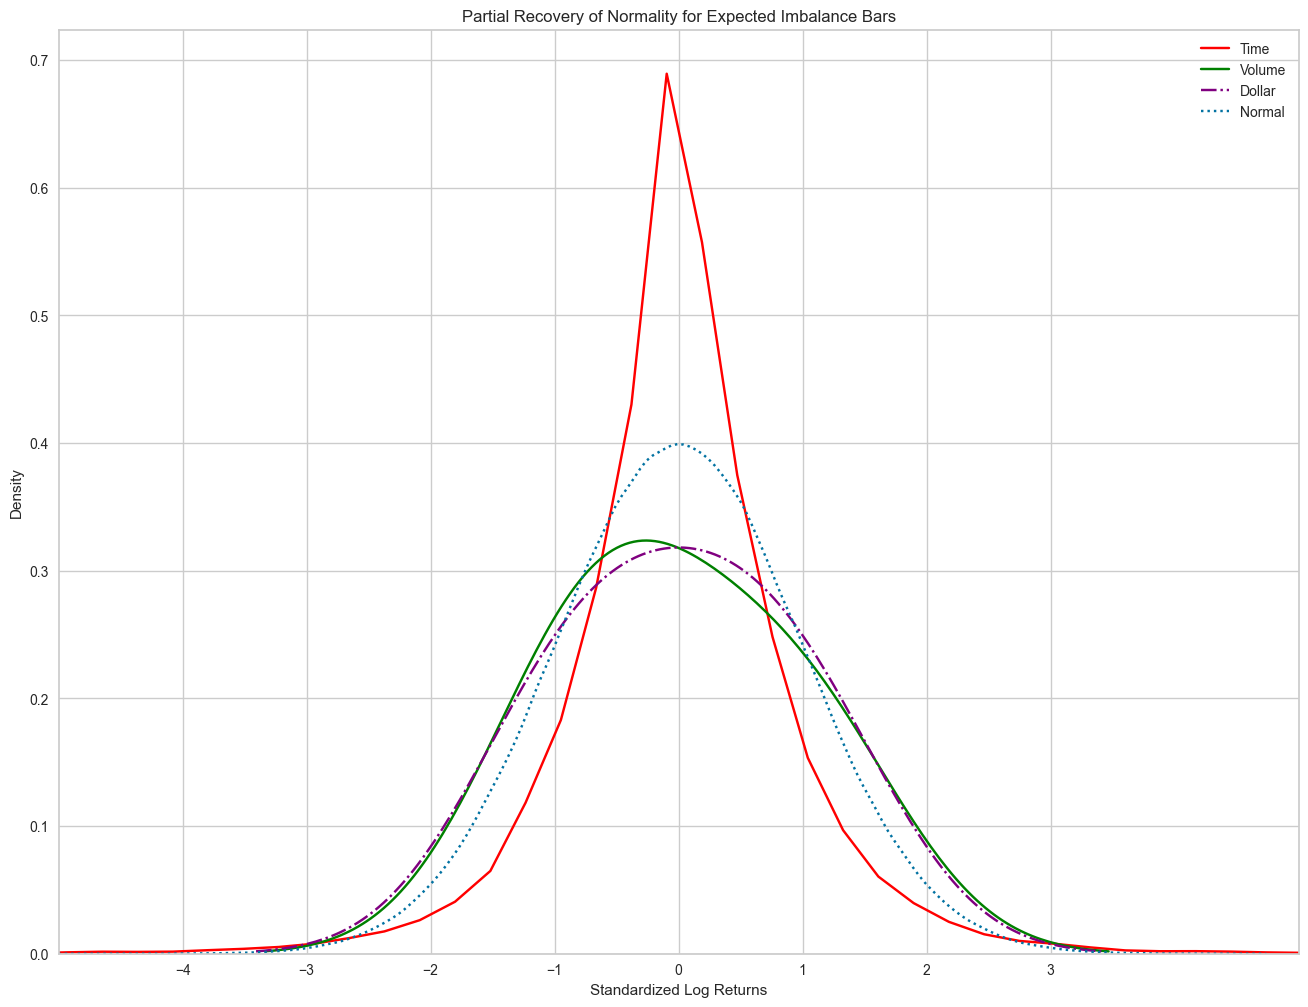

In [33]:
#Distribution Plot
plt.figure(figsize=(16, 12))
sns.kdeplot(time_standard, label="Time", color="red")
sns.kdeplot(EIB_tick_standard, label="Tick", color="blue")
sns.kdeplot(EIB_volume_standard, label="Volume", color="green")
sns.kdeplot(EIB_dollar_standard, label="Dollar", color="purple", linestyle="-.")
sns.kdeplot(np.random.normal(size=1000000), label="Normal", linestyle="dotted")
plt.xticks(range(-4, +4))

#labels
plt.xlabel("Standardized Log Returns")
plt.ylabel("Density")
plt.title(
    'Partial Recovery of Normality for Expected Imbalance Bars',
    loc='center', 
)
plt.xlim(-5, 5)
plt.legend()
plt.show()

## Run Bars

### Tick Run Bars

In [34]:
tick_run_bars = generate_info_driven_bars(sampling_method='expected_tick_run_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)
tick_run_bars.head()

Processing batch 0 with size 37909


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold


### Volume Run Bars

In [35]:


volume_run_bars = generate_info_driven_bars(sampling_method='expected_volume_run_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)
volume_run_bars.head()

Processing batch 0 with size 37909


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold


### Dollar Run Bars

In [36]:
dollar_run_bars = generate_info_driven_bars(sampling_method='expected_dollar_run_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)
dollar_run_bars.head()

Processing batch 0 with size 37909


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-22 22:39:56.272676+00:00,7194,118251.351562,118316.007812,111700.000000,116615.562500,40654.294086,20297.769021,20356.525065,7194,4.657780e+09,1.697780e+09
1,2025-08-29 14:08:47.042801+00:00,16757,116583.632812,117029.929688,108692.007812,108740.171875,57014.604967,25904.724602,31109.880364,9563,6.389160e+09,3.478733e+09
2,2025-09-08 14:10:43.702664+00:00,31150,108752.968750,113256.046875,107278.429688,112233.437500,62825.687540,31690.762642,31134.924897,14393,6.925749e+09,3.494400e+09
3,2025-09-12 19:54:32.382654+00:00,37250,112253.992188,116610.992188,110774.023438,116610.992188,33731.296646,17741.869407,15989.427239,6100,3.828365e+09,2.012302e+09


### Statistical Test

#### Log Return

In [37]:
tick_run_bars_returns = log_return(tick_run_bars['Close'])
volume_run_bars_returns = log_return(volume_run_bars['Close'])
dollar_run_bars_returns = log_return(dollar_run_bars['Close'])

####  Jarque–Bera test statistic 

In [ ]:
print("Jarque-Bera test statistic for time returns:", int(stats.jarque_bera(time_returns)[0]))
print("Jarque-Bera test statistic for tick run bars returns:", int(stats.jarque_bera(tick_run_bars_returns)[0]))
print("Jarque-Bera test statistic for volume run bars returns:", int(stats.jarque_bera(volume_run_bars_returns)[0]))
print("Jarque-Bera test statistic for dollar run bars returns:", int(stats.jarque_bera(dollar_run_bars_returns)[0]))

#### Shapiro-Wilk Test

In [ ]:
print("Shapiro-Wilk test statistic for time returns:", stats.shapiro(time_returns))
print("Shapiro-Wilk test statistic for tick run bars returns:", stats.shapiro(tick_run_bars_returns))
print("Shapiro-Wilk test statistic for volume run bars returns:", stats.shapiro(volume_run_bars_returns))
print("Shapiro-Wilk test statistic for dollar run bars returns:", stats.shapiro(dollar_run_bars_returns))

#### Kernel Density Estimate (KDE) plot

In [ ]:
#Standardize Data 
tick_run_bars_standard = (tick_run_bars_returns - tick_run_bars_returns.mean()) / tick_run_bars_returns.std()
volume_run_bars_standard = (volume_run_bars_returns  - volume_run_bars_returns.mean()) / volume_run_bars_returns.std()
dollar_run_bars_standard = (dollar_run_bars_returns - dollar_run_bars_returns.mean()) / dollar_run_bars_returns.std()

In [ ]:
#Distribution Plot
plt.figure(figsize=(16, 12))
sns.kdeplot(time_standard, label="Time", color="red")
sns.kdeplot(tick_run_bars_standard, label="Tick", color="blue")
sns.kdeplot(volume_run_bars_standard, label="Volume", color="green")
sns.kdeplot(dollar_run_bars_standard , label="Dollar", color="purple", linestyle="-.")
sns.kdeplot(np.random.normal(size=1000000), label="Normal", linestyle="dotted")
plt.xticks(range(-4, +4))

#labels
plt.xlabel("Standardized Log Returns")
plt.ylabel("Density")
plt.title(
    'Partial Recovery of Normality for Run Bars',
    loc='center', 
)
plt.xlim(-5, 5)
plt.legend()
plt.show()

# Additional Features

In [39]:
def grouped_features(raw_df, resumpling_df, feature_name, agg_func=np.sum):
    """
    Aggregate a feature between Tick Number ranges using a specified aggregation function.

    Parameters
    ----------
    raw_df : pd.DataFrame
        Full DataFrame with tick-by-tick data.
    resumpling_df : pd.DataFrame
        DataFrame with "Tick Number" boundaries (breakpoints).
    feature_name : str
        Column name in raw_df to aggregate (e.g., "ohlc_trades").
    agg_func : function, default=np.sum
        Aggregation function (e.g., np.sum, np.mean, np.max).

    Returns
    -------
    pd.DataFrame
        resumpling_df with the aggregated feature filled.
    """

    resumpling_df[feature_name] = np.nan  

    m = raw_df[feature_name]
    idx_list = resumpling_df.index.astype(int).to_list()

    if idx_list:
        idx_start = idx_list[0]
        idx_end = idx_list[0] + 1
        resumpling_df.loc[idx_start, feature_name] = agg_func(m.iloc[0:idx_end])

    for start, end in zip(idx_list, idx_list[1:]):
        resumpling_df.loc[end, feature_name] = agg_func(m.iloc[start:(end+1)])

    return resumpling_df

def last_state(raw_df,resumpling_df, feature_name):
    """
    Align the latest state of a feature from the raw dataframe
    onto the resampled dataframe at matching indices.

    Parameters
    ----------
    raw_df : pandas.DataFrame
        Original/raw dataset containing the feature of interest.
    resampling_df : pandas.DataFrame
        Resampled dataset whose index is aligned to raw_df.
    feature_name : str
        Column name (feature) to propagate from raw_df to resampling_df.

    Returns
    -------
    pandas.DataFrame
        Updated resampling_df with a new column `feature_name`
        containing the values from raw_df at matching indices. 

    """

    resumpling_df[feature_name] = np.nan  
    idx_list = resumpling_df.index.to_list()
    for i in idx_list:
        resumpling_df.loc[i,feature_name] = raw_df[feature_name][i]
    return resumpling_df

def price_vwap(raw_df, resumpling_df, feature_name, vol_colum_name ='ohlc_volume'):
    """
    Compute VWAP (Volume-Weighted Average Price) for each resampled bar.

    Parameters
    ----------
    raw_df : pandas.DataFrame
        Original dataframe with price and volume data.
    resampling_df : pandas.DataFrame
        Resampled dataframe that defines the bar boundaries (by index).
    feature_name : str
        Column name in raw_df containing prices to weight.
    vol_column_name : str, default="ohlc_volume"
        Column name in raw_df containing volume weights.

    Returns
    -------
    pandas.DataFrame
        Updated resampling_df with an extra column containing VWAP values
        for each resampled interval.
    """
    
    resumpling_df[feature_name] = np.nan  

    m = raw_df[feature_name]
    vol = raw_df[vol_colum_name]

    idx_list = resumpling_df.index.astype(int).to_list()

    if idx_list:
        idx_start = idx_list[0]
        idx_end = idx_list[0] + 1

        resumpling_df.loc[idx_start, feature_name] = np.average(m[0:idx_end], weights=vol[0:idx_end])

    for start, end in zip(idx_list, idx_list[1:]):
        resumpling_df.loc[end, feature_name] = np.average(m[start:(end+1)], weights=vol[start:(end+1)])

    return resumpling_df

In [40]:
def aggregate_features(input_df, sampling_df):

    """
    Aggregate raw features into resampled bars using different strategies.

    Parameters
    ----------
    input_df : pandas.DataFrame
        Raw tick-level dataframe containing all features.
    sampling_df : pandas.DataFrame
        DataFrame with resampled bar boundaries.
        Must contain a 'Tick Number' column to align with input_df.

    Returns
    -------
    pandas.DataFrame
        Updated sampling_df containing aggregated features.
    """

    sampling_df =sampling_df.set_index("Tick Number")

    vol_sum = ['ohlc_trades','ohlc_taker_base','ohlc_taker_quote',
            'tr_volume_base','tr_volume_quote']

    last_states = ['l1_bid','l1_ask','l1_mid','l1_spread',
                'l1_bid_qty','l1_ask_qty','l1_imbalance',
                'l2_bid_depth','l2_ask_depth','l2_depth_asymmetry',
                'l2_bid_vwap','l2_ask_vwap','l2_bid_slope','l2_ask_slope',
                'spot_price','perp_mark_price','basis_abs','basis_pct',
                'funding_rate','next_funding_time_ms']

    mean_bar= ['tr_buy_sell_imbalance']

    weighted_mean = ['tr_vwap']

    #total
    for i in vol_sum:
        sampling_df  = grouped_features(raw_df=input_df, 
                                        resumpling_df=sampling_df , 
                                        feature_name=i, 
                                        agg_func=np.sum)
    #last value
    for j in last_states:
        sampling_df  = last_state(raw_df=input_df,
                                    resumpling_df=sampling_df ,
                                    feature_name=j)
    #average value   
    for k in mean_bar:
        sampling_df  = grouped_features(raw_df=input_df, 
                                        resumpling_df=sampling_df , 
                                        feature_name=k, 
                                        agg_func=np.mean)
    #weighted average
    for _ in weighted_mean:
        sampling_df  = price_vwap(raw_df=input_df, 
                                    resumpling_df=sampling_df , 
                                    feature_name= _,
                                    vol_colum_name ='ohlc_volume')
        
    return sampling_df

In [41]:
df_features = aggregate_features(input_df=df, sampling_df=dollar_run_bars)
df_features

,Date Time,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,...,l2_bid_slope,l2_ask_slope,spot_price,perp_mark_price,basis_abs,basis_pct,funding_rate,next_funding_time_ms,tr_buy_sell_imbalance,tr_vwap
Tick Number,,,,,,,,,,,,,,,,,,,,,
7194,2025-08-22 22:39:56.272676+00:00,118251.351562,118316.007812,111700.000000,116615.562500,40654.294086,20297.769021,20356.525065,7194,4.657780e+09,...,-17.814844,3.227623,116583.617188,116540.296875,-43.320000,-0.000372,0.000100,1.755907e+12,-0.035910,114524.781250
16757,2025-08-29 14:08:47.042801+00:00,116583.632812,117029.929688,108692.007812,108740.171875,57014.604967,25904.724602,31109.880364,9563,6.389160e+09,...,-49.723106,1.319228,108720.359375,108703.531250,-16.825142,-0.000155,0.000014,1.756483e+12,-0.036090,112181.765625
31150,2025-09-08 14:10:43.702664+00:00,108752.968750,113256.046875,107278.429688,112233.437500,62825.687540,31690.762642,31134.924897,14393,6.925749e+09,...,-2.260226,2.333816,112253.976562,112217.179688,-36.803734,-0.000328,0.000100,1.757347e+12,-0.054070,110217.695312
37250,2025-09-12 19:54:32.382654+00:00,112253.992188,116610.992188,110774.023438,116610.992188,33731.296646,17741.869407,15989.427239,6100,3.828365e+09,...,-5.199858,73.841431,116657.562500,116594.250000,-63.310051,-0.000543,-0.000001,1.757722e+12,-0.089403,113474.515625
